imports and includes

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import graphviz
import sqlite3
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, RocCurveDisplay
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.svm import SVC


#just to make graphviz work on my computer, having issues with the path
import os
os.environ["PATH"] += r";C:\Program Files\Graphviz\bin"


enforce copy on write

In [2]:
#copy on write
pd.set_option('mode.copy_on_write', True)

In [3]:
cwd = Path.cwd()
root = cwd.parent
data = Path(root / 'data')

In [4]:
# generate dataframes for data files
country_platform_summary = Path(data / 'country_platform_summary_2025.csv')
cps_df = pd.read_csv(country_platform_summary)

DATA_DICTIONARY = Path(data / 'DATA_DICTIONARY.csv')
DD_df = pd.read_csv(DATA_DICTIONARY)

monthly_trends_2025 = Path(data / 'monthly_trends_2025.csv')
trends_df = pd.read_csv(monthly_trends_2025)

top_creators = Path(data / 'top_creators_impact_2025.csv')
creators_df = pd.read_csv(top_creators)


top_hashtags = Path(data / 'top_hashtags_2025.csv')
hashtags_df = pd.read_csv(top_hashtags)

yt_tt_trends = Path(data / 'youtube_shorts_tiktok_trends_2025.csv')
yt_tt_trends_df = pd.read_csv(yt_tt_trends)

yt_tt_trends_csv_ML = Path(data / 'youtube_shorts_tiktok_trends_2025.csv_ML.csv')
yt_tt_trends_ML_df = pd.read_csv(yt_tt_trends_csv_ML)

Lets add sql functionality. We need to upload all the dataframes to a sql database first.
Note: Below cell may need to be commented out if re-running all the jupyter notebook cells

In [5]:
#create database file
db_path = root / 'data' / 'virality_analysis.db'

#open connection to database
connection = sqlite3.connect(db_path)

#write dataframes to sql tables
cps_df.to_sql("country_platform_summary", connection, if_exists="replace", index=False)
DD_df.to_sql("data_dictionary", connection, if_exists="replace", index=False)
trends_df.to_sql("monthly_trends_2025", connection, if_exists="replace", index=False)
creators_df.to_sql("top_creators_impact_2025", connection, if_exists="replace", index=False)
hashtags_df.to_sql("top_hashtags_2025", connection, if_exists="replace", index=False)
yt_tt_trends_df.to_sql("yt_tt_trends_raw", connection, if_exists="replace", index=False)
yt_tt_trends_ML_df.to_sql("yt_tt_trends_ml", connection, if_exists="replace", index=False)

#and close the connection
connection.close()

#set up sqlalchemy engine to use for connecting to the database
#note: sql does not like strings or variables passed from python
db_path = db_path.resolve()
engine = create_engine(f'sqlite:///{db_path.as_posix()}')#convert to posix for windows compatibility
engine

Engine(sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db)

In [6]:
try:
    connection.close()
except:
    pass

Run this once to load sql --->

In [7]:


%reload_ext sql
%sql engine


SQL code below will be for configurations:
1. set display limit to none so we can see entire tables by default

In [8]:
%config SqlMagic.displaylimit = None

displaylimit: Value None will be treated as 0 (no limit)

Lets check to see if all our df's are in the database:

In [9]:
%%sql
SELECT name
FROM sqlite_master
WHERE type = 'table'

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

name
country_platform_summary
data_dictionary
monthly_trends_2025
top_creators_impact_2025
top_hashtags_2025
yt_tt_trends_raw
yt_tt_trends_ml


# Few things to look into here before we get started
1. Look into data dictionary and understand the insight provided relating to data
2. Check each datasets contents and understand data from each set
3. Compare the youtube and tiktok trends files, how they differ, and why

How are we going to define virality?
Option 1: Base it on views
Option 2: Base it on engagement rate
Option 3: A combination

# 1. Look into data dictionary and understand the insight provided relating to data

In [10]:
# observe data dictionary shape
print("Shape of Data Dictionary = ", DD_df.shape)

Shape of Data Dictionary =  (58, 2)


In [11]:
%%sql
SELECT * 
FROM data_dictionary
--using sql allowed us to see the entire table by default, cool

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

column,description
platform,Platform (TikTok/YouTube)
country,Country ISO-2 code
region,Region macro label (if available)
language,Primary language inferred from country (fallback to 'en')
category,Video category (if available)
hashtag,Primary hashtag aligned with genre
title_keywords,Short realistic title-like keywords
author_handle,"Creator handle/channel (brand-like, synthetic)"
sound_type,Sound type (if present)
music_track,Music track (if present)


Here we can see the that data has been organized and outlined clearly. We have a well documented reference point for analyzing each of these datasets.

Note: Missing data identified w "NaN"

# 2. Check each datasets contents and understand data from each set

Initial look: Summary

In [12]:
# lets see what we can understand from these datasets, lets begin with summary dataset
print("Shape of Summary Dataset = ", cps_df.shape)

Shape of Summary Dataset =  (60, 14)


In [13]:
# another smaller dataset lets take a look
cps_df.head()

,country,platform,total_videos,total_views,median_er,p95_views,avg_duration,avg_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_engagement_per_1k,top_hashtag,top_hashtag_views
0,Ae,TikTok,1017,102064271,0.0900,325484.40,29.7335,13785.7142,0.0077,0.0068,0.0072,92.4015,#FYP,26292844
1,Ae,YouTube,641,67638733,0.0492,332142.00,41.8721,14381.0054,0.0043,0.0038,0.0040,51.2265,#FYP,18272805
2,Ar,TikTok,1032,103715112,0.0877,311367.55,29.7025,13126.5611,0.0076,0.0067,0.0071,90.0953,#FYP,27220930
3,Ar,YouTube,629,57036717,0.0491,271985.20,40.7886,12136.0476,0.0042,0.0037,0.0040,50.4033,#FYP,12738216
4,Au,TikTok,959,96885399,0.0898,306511.80,29.7404,14376.2279,0.0077,0.0068,0.0073,92.4227,#FYP,26396116


In [14]:
cps_df.tail()

,country,platform,total_videos,total_views,median_er,p95_views,avg_duration,avg_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_engagement_per_1k,top_hashtag,top_hashtag_views
55,Tr,YouTube,704,66369328,0.0486,287205.70,40.4616,13241.4636,0.0042,0.0037,0.0041,50.4683,#FYP,17739070
56,Us,TikTok,1038,99338866,0.0894,306683.60,30.2649,14159.4068,0.0077,0.0068,0.0073,92.1015,#FYP,23785161
57,Us,YouTube,642,65109764,0.0496,323309.55,40.0561,14268.7101,0.0044,0.0038,0.0040,51.8907,#FYP,16188541
58,Za,TikTok,962,90262395,0.0887,283934.60,31.2027,12976.8724,0.0076,0.0067,0.0071,91.2857,#FYP,21084944
59,Za,YouTube,641,60673149,0.0497,280924.00,40.1576,13108.5168,0.0042,0.0038,0.0041,50.9622,#FYP,14840115


In [15]:
%%sql
SELECT *
FROM country_platform_summary
--checking out the entire cps table with sql

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

country,platform,total_videos,total_views,median_er,p95_views,avg_duration,avg_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_engagement_per_1k,top_hashtag,top_hashtag_views
Ae,TikTok,1017,102064271,0.09,325484.39999999973,29.7335,13785.7142,0.0077,0.0068,0.0072,92.4015,#FYP,26292844
Ae,YouTube,641,67638733,0.0492,332142.0,41.8721,14381.0054,0.0043,0.0038,0.004,51.2265,#FYP,18272805
Ar,TikTok,1032,103715112,0.0877,311367.5499999999,29.7025,13126.5611,0.0076,0.0067,0.0071,90.0953,#FYP,27220930
Ar,YouTube,629,57036717,0.0491,271985.2,40.7886,12136.0476,0.0042,0.0037,0.004,50.4033,#FYP,12738216
Au,TikTok,959,96885399,0.0898,306511.7999999996,29.7404,14376.2279,0.0077,0.0068,0.0073,92.4227,#FYP,26396116
Au,YouTube,634,60555264,0.0491,267301.3500000001,39.9874,12478.4617,0.0042,0.0037,0.0039,50.3284,#FYP,13817303
Br,TikTok,979,99513183,0.088,325268.4999999994,30.5975,14547.0123,0.0076,0.0067,0.007,91.5484,#FYP,28395970
Br,YouTube,707,71033014,0.0486,321959.7999999998,41.5064,14249.9427,0.0042,0.0037,0.0039,49.995,#FYP,15886325
Ca,TikTok,989,101886293,0.09,314665.1999999995,29.9596,13545.442,0.0077,0.0069,0.0075,92.6898,#FYP,23718366
Ca,YouTube,643,61091703,0.0489,321929.9,41.0404,12697.5209,0.0042,0.0037,0.004,50.2693,#FYP,13572413


Seems to be in alphabetical order of country codes. This gives us a general summary of tiktok and youtube statistics such as, video vount, view count, top hashtag per country and a viewcount of these top hashtags. Other details provided include the averages of durations, comment ratios, save and share rates, and engagement.

Initial look: Monthly Trends

In [16]:
print("Shape of Monthly Trends = ", trends_df.shape)

Shape of Monthly Trends =  (480, 8)


In [17]:
trends_df.head()

,country,platform,year_month,n_videos,views,avg_er,avg_velocity,trend_label
0,AE,TikTok,2025-01,130,14474636,0.093197,18357.548923,steady
1,AE,TikTok,2025-02,112,11873208,0.092006,14471.823839,declining
2,AE,TikTok,2025-03,129,15551725,0.088624,15883.138605,rising
3,AE,TikTok,2025-04,118,9625618,0.093185,11284.687373,declining
4,AE,TikTok,2025-05,130,12041755,0.092336,12483.081231,steady


In [18]:
trends_df.tail()

,country,platform,year_month,n_videos,views,avg_er,avg_velocity,trend_label
475,ZA,YouTube,2025-04,76,6748722,0.055431,14162.785789,declining
476,ZA,YouTube,2025-05,90,8986166,0.048751,10996.790444,rising
477,ZA,YouTube,2025-06,61,5444650,0.048903,13388.686721,declining
478,ZA,YouTube,2025-07,64,6489859,0.050448,16987.705000,steady
479,ZA,YouTube,2025-08,82,7245449,0.051070,10553.309390,steady


Keeps same organization, alphabetical by country code but also seems to be alphabetical for platform (Tiktok->Youtube). Data defined as a total view count of n videos each month from 2025, per platform, per country. Other metrics included: average engagement rate, velocity, and defined trend label.

Initial look: Top creators impact set

In [19]:
print("Shape of Top Creators Impact = ", creators_df.shape)

Shape of Top Creators Impact =  (1000, 20)


In [20]:
creators_df.head()

,author_handle,platform,n_videos,views,avg_er,likes_sum,dislikes_sum,comments_sum,shares_sum,saves_sum,total_engagements,avg_engagement_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_like_dislike_ratio,avg_engagement_per_1k,avg_like_rate,avg_dislike_rate,creator_avg_views
0,UrbanVision,TikTok,136,17938952,0.091914,1267238,36094,142403,125916,124572,1660129,17957.902500,0.007648,0.006849,0.007302,49.735210,91.913699,0.070115,0.001887,120866.4
1,BeyondStudio,TikTok,135,17085072,0.087916,1121223,31594,123017,114620,130934,1489794,17890.303481,0.007439,0.006496,0.006724,49.875449,87.915533,0.067256,0.001922,116192.9
2,StreetVision,TikTok,133,16843324,0.093018,1228515,28953,129169,114222,138762,1610668,18574.954962,0.007454,0.006886,0.007555,54.076138,93.018098,0.071123,0.001870,116083.5
3,NextMedia,TikTok,148,16325236,0.092222,1161803,29124,128881,110655,119691,1521030,15570.731419,0.007605,0.006733,0.007361,53.285924,92.222081,0.070523,0.001818,106288.7
4,PrimeLabs,TikTok,135,16240032,0.092307,1095828,28067,119613,105152,112859,1433452,15412.244000,0.007698,0.006751,0.007717,52.907430,92.306830,0.070140,0.001816,103134.2


In [21]:
creators_df.tail()

,author_handle,platform,n_videos,views,avg_er,likes_sum,dislikes_sum,comments_sum,shares_sum,saves_sum,total_engagements,avg_engagement_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_like_dislike_ratio,avg_engagement_per_1k,avg_like_rate,avg_dislike_rate,creator_avg_views
995,GuruYuki,YouTube,21,1865526,0.050216,80938,8694,9343,8018,7906,106205,9052.485714,0.004140,0.003819,0.004129,14.826263,50.215571,0.038128,0.003620,86547.9
996,OfficialSofia,TikTok,18,1858897,0.090631,126563,2813,13248,11468,15048,166327,9671.951111,0.008100,0.006263,0.006582,54.694049,90.631278,0.069687,0.001562,102487.9
997,TravelByNoor,YouTube,18,1857824,0.056072,69365,6231,7680,6363,5358,88766,12190.825556,0.004760,0.004138,0.003585,13.591240,56.071944,0.043590,0.004124,96440.7
998,TVDiego,YouTube,20,1856301,0.055188,71928,6373,8041,7128,8984,96081,13751.414500,0.004523,0.004063,0.004867,13.170205,55.187650,0.041735,0.003821,108068.4
999,BeautyByAmr,TikTok,21,1854548,0.092891,117331,2368,10812,10748,9943,148834,16431.634286,0.007505,0.006813,0.006816,49.267076,92.890762,0.071757,0.001755,90734.5


1000 creators across youtube and tiktok, ranked by number of views. Other metrics included to compare how many videos each creator posted in 2025, and each corresponding statistic, average engagement rate, total number of likes/dislikes, total comments, shares, saves etc.

Intial look: top hashtags

In [22]:
print("Shape of Top Hashtags 2025 = ", hashtags_df.shape)

Shape of Top Hashtags 2025 =  (82, 18)


In [23]:
hashtags_df.head()

,platform,hashtag,n_videos,views,likes,comments,shares,saves,avg_er,avg_engagement_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_like_dislike_ratio,avg_engagement_per_1k,avg_like_rate,avg_dislike_rate,total_engagements
0,TikTok,#FYP,7379,734064265,51402240,5651829,4998382,5348188,0.091838,13954.979633,0.007692,0.006783,0.007221,51.436016,91.837843,0.070141,0.001892,67400639
1,TikTok,#GRWM,1013,111331419,7726251,843072,753230,777258,0.091320,15906.769319,0.007638,0.006746,0.007104,49.449781,91.319729,0.069833,0.001921,10099811
2,TikTok,#Comedy,762,79538424,5748752,620867,551845,606968,0.092762,14930.337533,0.007677,0.006833,0.007625,49.351872,92.761520,0.070627,0.001941,7528432
3,TikTok,#Lifestyle,782,78531438,5437932,590141,532055,578370,0.091395,13480.843389,0.007536,0.006713,0.007324,51.094024,91.394959,0.069822,0.001843,7138498
4,TikTok,#Relatable,795,76879158,5452690,603507,527910,557667,0.092813,13024.526164,0.007796,0.006919,0.007223,48.388414,92.813268,0.070875,0.001966,7141774


In [24]:
hashtags_df.tail()

,platform,hashtag,n_videos,views,likes,comments,shares,saves,avg_er,avg_engagement_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_like_dislike_ratio,avg_engagement_per_1k,avg_like_rate,avg_dislike_rate,total_engagements
77,YouTube,#Streamer,286,26276852,1060622,111847,100032,114928,0.051714,11069.796434,0.004169,0.003796,0.004284,15.895462,51.714346,0.039465,0.003200,1387429
78,YouTube,#Beauty,288,24769612,913494,104134,87134,96478,0.049295,11229.686458,0.004172,0.003589,0.003890,16.099786,49.294625,0.037644,0.003102,1201240
79,YouTube,#Crafts,35,4348818,152466,14969,14297,20097,0.048971,12933.123429,0.003670,0.003526,0.004000,15.080030,48.970571,0.037775,0.003265,201829
80,YouTube,#DIY,26,2760492,122394,12845,12735,10167,0.053638,15458.086923,0.004445,0.003892,0.004029,15.933150,53.637692,0.041272,0.003386,158141
81,YouTube,#LifeHacks,31,2435911,96785,10526,9340,10245,0.053519,12360.546129,0.004519,0.003886,0.004273,13.785287,53.518516,0.040840,0.003712,126896


Popular hashtags on both platforms ordered descending by view count or possibly number of likes. This could suggest a relationship between these two columns and even number of comments, shares and saves. Investigate these relationships later.

Lets do some cleaning, first check for null values across each data set

In [25]:
cps_df.info()
print(cps_df.isnull().sum())
DD_df.info()
print(DD_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                60 non-null     object 
 1   platform               60 non-null     object 
 2   total_videos           60 non-null     int64  
 3   total_views            60 non-null     int64  
 4   median_er              60 non-null     float64
 5   p95_views              60 non-null     float64
 6   avg_duration           60 non-null     float64
 7   avg_velocity           60 non-null     float64
 8   avg_comment_ratio      60 non-null     float64
 9   avg_share_rate         60 non-null     float64
 10  avg_save_rate          60 non-null     float64
 11  avg_engagement_per_1k  60 non-null     float64
 12  top_hashtag            60 non-null     object 
 13  top_hashtag_views      60 non-null     int64  
dtypes: float64(8), int64(3), object(3)
memory usage: 6.7+ KB
cou

In [26]:
trends_df.info()
print(trends_df.isnull().sum())
creators_df.info()
print(creators_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       480 non-null    object 
 1   platform      480 non-null    object 
 2   year_month    480 non-null    object 
 3   n_videos      480 non-null    int64  
 4   views         480 non-null    int64  
 5   avg_er        480 non-null    float64
 6   avg_velocity  480 non-null    float64
 7   trend_label   480 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 30.1+ KB
country         0
platform        0
year_month      0
n_videos        0
views           0
avg_er          0
avg_velocity    0
trend_label     0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author_handle            10

In [27]:
hashtags_df.info()
print(hashtags_df.isnull().sum())
yt_tt_trends_df.info()
print(yt_tt_trends_df.isnull().sum())
yt_tt_trends_ML_df.info()
print(yt_tt_trends_ML_df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   platform                 82 non-null     object 
 1   hashtag                  82 non-null     object 
 2   n_videos                 82 non-null     int64  
 3   views                    82 non-null     int64  
 4   likes                    82 non-null     int64  
 5   comments                 82 non-null     int64  
 6   shares                   82 non-null     int64  
 7   saves                    82 non-null     int64  
 8   avg_er                   82 non-null     float64
 9   avg_engagement_velocity  82 non-null     float64
 10  avg_comment_ratio        82 non-null     float64
 11  avg_share_rate           82 non-null     float64
 12  avg_save_rate            82 non-null     float64
 13  avg_like_dislike_ratio   82 non-null     float64
 14  avg_engagement_per_1k    82 

In [28]:
print(yt_tt_trends_df.head())

  platform country   region language category     hashtag  \
0   TikTok      Jp     Asia       ja   Gaming  #Lifestyle   
1   TikTok      Se   Europe       sv     Food     #Sports   
2   TikTok      Za   Africa       en      Art    #Workout   
3   TikTok      Kr     Asia       ko     News    #Esports   
4   TikTok      Au  Oceania       en   Beauty     #Comedy   

                  title_keywords    author_handle sound_type     music_track  \
0        Night Routine — College       NextVision   trending       8bit loop   
1      Morning Routine — College  DailyVlogsDiego   trending     Street vibe   
2        Night Routine — College        BeyondHub   licensed     Gallery pad   
3     Best Settings for Fortnite          NextHub   original   Neutral piano   
4  When your friend is Beginners    LucasOfficial   licensed  Soft glam loop   

   ...  traffic_source  is_weekend                            row_id  \
0  ...        External           1  2e681528d17a1fe1986857942536ec27   
1  ...  

# 3. Compare Youtube and Tiktok Trends files

Initial look: youtube shorts tiktok trends 2025

In [29]:
print("Shape of youtube shorts tiktok trends 2025 = ", yt_tt_trends_df.shape)

Shape of youtube shorts tiktok trends 2025 =  (48079, 58)


In [30]:
yt_tt_trends_df.head()

,platform,country,region,language,category,hashtag,title_keywords,author_handle,sound_type,music_track,...,traffic_source,is_weekend,row_id,engagement_total,like_rate,dislike_rate,engagement_per_1k,engagement_like_rate,engagement_comment_rate,engagement_share_rate
0,TikTok,Jp,Asia,ja,Gaming,#Lifestyle,Night Routine — College,NextVision,trending,8bit loop,...,External,1,2e681528d17a1fe1986857942536ec27,30317,0.086159,0.004004,120.069,0.086159,0.012555,0.007830
1,TikTok,Se,Europe,sv,Food,#Sports,Morning Routine — College,DailyVlogsDiego,trending,Street vibe,...,Search,0,2e35fa0b2978b9cae635839c1d4e9e74,30577,0.085298,0.002421,113.005,0.085298,0.007850,0.007791
2,TikTok,Za,Africa,en,Art,#Workout,Night Routine — College,BeyondHub,licensed,Gallery pad,...,External,1,0d88a011235a82244995ef52961f9502,503,0.049154,0.001625,68.111,0.049154,0.004469,0.005146
3,TikTok,Kr,Asia,ko,News,#Esports,Best Settings for Fortnite,NextHub,original,Neutral piano,...,Search,1,e15cff7621ed3f9eb9d2c97c841be0f3,7828,0.086257,0.003164,108.156,0.086257,0.011205,0.005292
4,TikTok,Au,Oceania,en,Beauty,#Comedy,When your friend is Beginners,LucasOfficial,licensed,Soft glam loop,...,ForYou,1,d696b4f0a50ea70e7cb5021be7e198ec,1171,0.051441,0.001175,72.400,0.051441,0.004204,0.004142


In [31]:
yt_tt_trends_df.tail()

,platform,country,region,language,category,hashtag,title_keywords,author_handle,sound_type,music_track,...,traffic_source,is_weekend,row_id,engagement_total,like_rate,dislike_rate,engagement_per_1k,engagement_like_rate,engagement_comment_rate,engagement_share_rate
48074,YouTube,Ke,Africa,sw,Lifestyle,#Motivation,Weekly Reset — Beginners,NoahChannel,licensed,Chill guitar,...,Search,0,a756bd218ad29bce51bad0fac806a857,2904,0.025804,0.001247,33.216,0.025804,0.003454,0.002059
48075,YouTube,Sa,Asia,ar,Art,#DanceChallenge,Weekly Reset — Beginners,MrYuki,trending,Gallery pad,...,Home,1,0aeb762f68a9867eaf0b937006933021,2461,0.040411,0.005011,49.725,0.040411,0.003213,0.003617
48076,YouTube,Kr,Asia,ko,Science,#Comedy,When your friend is 2025,LifeOfAyaka,original,Lab beeps,...,Suggested,1,78ebd3268e18a3033895739c44680d82,1415,0.033513,0.003593,43.827,0.033513,0.004027,0.004119
48077,YouTube,Br,South America,pt,Pets,#OOTD,GRWM: Beginners Edition,TechieNoah,trending,Cute whistle,...,Home,1,67fd2032ade8be89da4c0208fbc05596,2457,0.043857,0.003594,59.272,0.043857,0.006465,0.003088
48078,YouTube,Pl,Europe,pl,Education,#Streamer,New Patch Tips for Fortnite,BeyondStudio,original,Calm piano,...,External,0,d985bcfe0e19119e396e87fbc4f7ef5d,3966,0.049392,0.005831,62.167,0.049392,0.004373,0.005298


Trending content from tiktok and youtube across various countries including relevant metrics. 

# Note: I'm unsure how these are defined as trending, what metrics they're organized by.

Initial look: youtube shorts tiktok trends 2025 ML

In [32]:
print("Shape of youtube shorts tiktok trends 2025 ML = ", yt_tt_trends_ML_df.shape)

Shape of youtube shorts tiktok trends 2025 ML =  (50000, 32)


Note different size from yt_tt_trends

In [33]:
yt_tt_trends_ML_df.head()

,trend_label,platform,region,language,category,traffic_source,device_brand,creator_tier,title_len,text_richness,...,share_hashtag_interaction,platform_cat,region_cat,language_cat,category_cat,traffic_source_cat,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost
0,stable,youtube,Africa,es,Food,search,samsung,nano,2,1.999998,...,0.056675,1,0,3,3,4,5,3,9.999990,0
1,stable,youtube,Europe,it,Comedy,feed,apple,micro,2,1.999998,...,0.092987,1,3,6,1,1,0,1,3.999996,0
2,stable,tiktok,Americas,en,Tech,search,google,micro,2,1.999998,...,0.064086,0,1,2,9,4,1,1,9.999990,0
3,rising,tiktok,Americas,ar,Comedy,feed,huawei,mid,2,1.999998,...,0.182443,0,1,0,1,1,2,2,3.999996,0
4,stable,tiktok,Americas,pt,Beauty,search,apple,nano,2,1.999998,...,0.098327,0,1,9,0,4,0,3,9.999990,0


In [34]:
yt_tt_trends_ML_df.tail()

,trend_label,platform,region,language,category,traffic_source,device_brand,creator_tier,title_len,text_richness,...,share_hashtag_interaction,platform_cat,region_cat,language_cat,category_cat,traffic_source_cat,device_brand_cat,creator_tier_cat,richness_traffic_interaction,weekend_hashtag_boost
49995,stable,youtube,Africa,en,Food,profile,samsung,nano,2,1.999998,...,0.032991,1,0,2,3,3,5,3,7.999992,0
49996,stable,tiktok,Americas,en,News,hashtag,apple,micro,3,2.999997,...,0.065294,0,1,2,7,2,0,1,8.999991,0
49997,stable,youtube,Americas,hi,Lifestyle,hashtag,samsung,mid,2,1.999998,...,0.046140,1,1,5,5,2,5,2,5.999994,0
49998,declining,youtube,Asia,hi,News,hashtag,samsung,nano,3,2.999997,...,0.014437,1,2,5,7,2,5,3,8.999991,1
49999,stable,youtube,Europe,en,Tech,feed,samsung,micro,2,1.999998,...,0.080755,1,3,2,9,1,5,1,3.999996,0


# another one idk how to define

Quite different from other dataset, including a trend label...

Lets define our virality metric. Going to use the trends dataset for this because it is huge and has many useful categories

In [35]:
#Option 1:
# viral_threshold = yt_tt_trends_df['views'].quantile(.95)
# yt_tt_trends_df['is_viral'] = (yt_tt_trends_df['views] >= viral_threshold).astype(int)

#Option 2:
viral_threshold = yt_tt_trends_df['engagement_per_1k'].mean() + 2*yt_tt_trends_df['engagement_per_1k'].std()
yt_tt_trends_df['is_viral'] = (yt_tt_trends_df['engagement_per_1k'] >= viral_threshold).astype(int)

viral_threshold2 = hashtags_df['avg_engagement_per_1k'].mean() + 2*hashtags_df['avg_engagement_per_1k'].std()
hashtags_df['is_viral'] = (hashtags_df['avg_engagement_per_1k'] >= viral_threshold2).astype(int)

# Next Steps: EDA

Now that we have a clearer view of each set and its contents, we want to start exploring the data and the relationships columns might hold with each other. Where should we start?

I want to begin by trying to paint this picture with that summary data, this way we can infer possible relationships, and confirm those using the raw data to help us further understand what succeeds in social media and why.

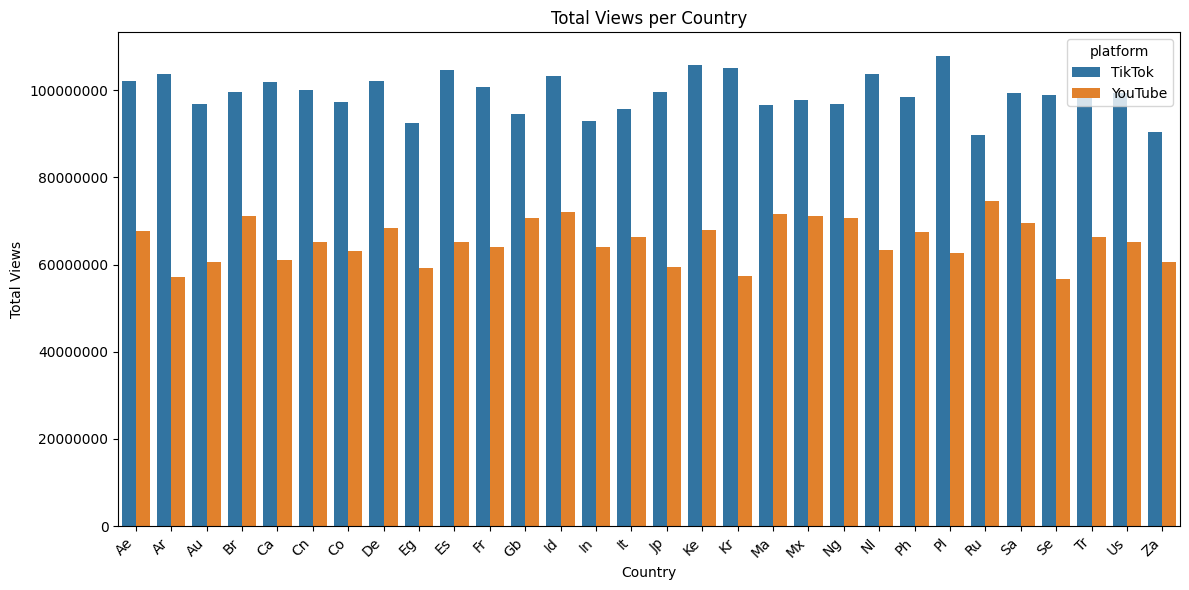

In [36]:
# lets look at the total views and videos for each country on both platforms

plt.figure(figsize=(12, 6))
sns.barplot(data=cps_df, x="country", y="total_views", hue="platform")

plt.title("Total Views per Country")
plt.xlabel("Country")
plt.ylabel("Total Views")
plt.xticks(rotation=45, ha='right')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

It's clear from this that TikTok garners far more views than youtube across all these countries. This could indicate that short form content has far more potential to go viral, or that there are simply more users on tiktok. But how does engagement rate and other metrics stack up when comparing the two?


Lets take a look at the monthly trends dataset

Text(0.5, 29.00000000000003, 'Country')

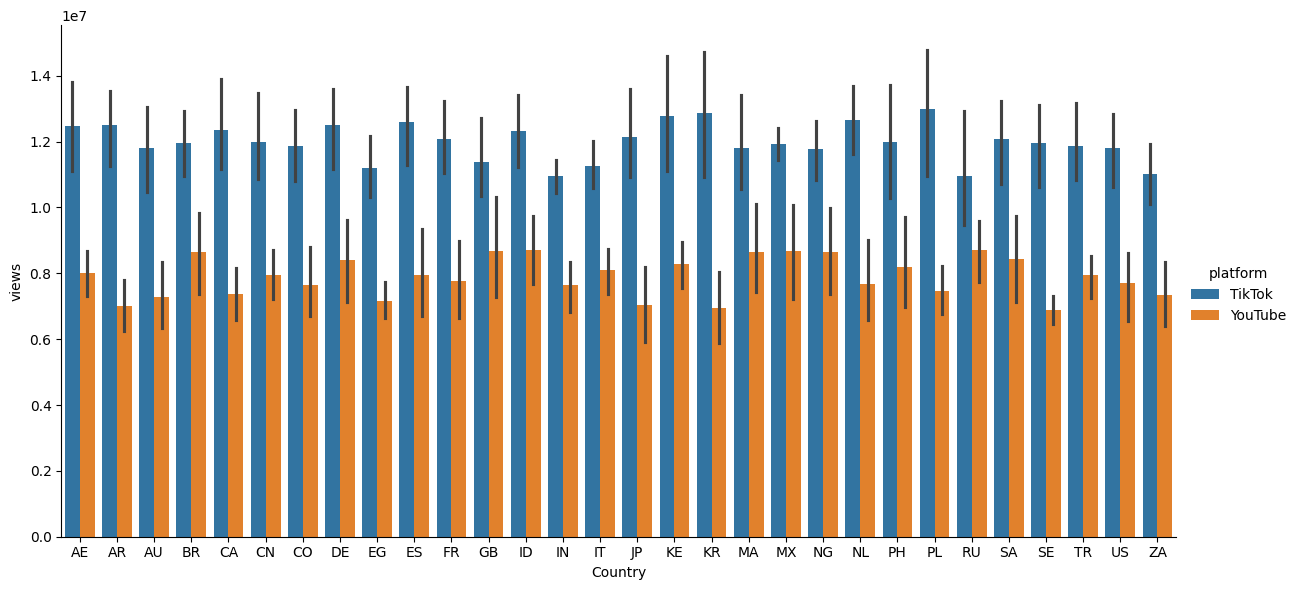

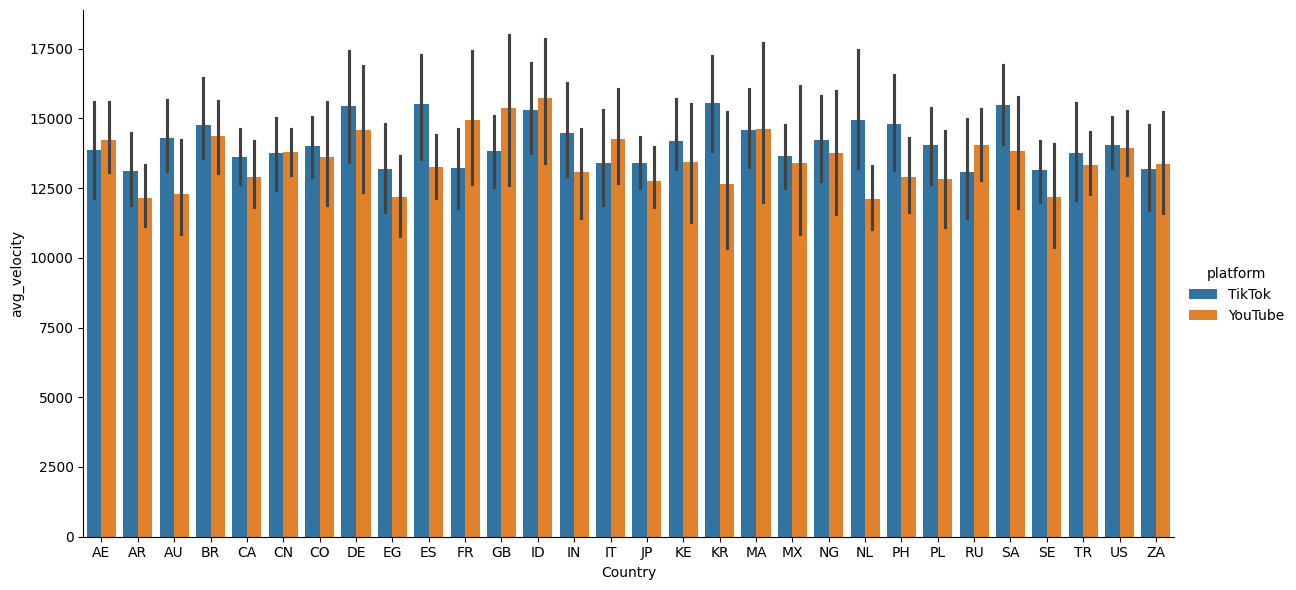

In [37]:
trends_df.head()
sns.catplot(data=trends_df, x='country', y='views', hue = 'platform', kind='bar', height=6, aspect=2)
plt.xlabel('Country')
sns.catplot(data=trends_df, x='country', y='avg_velocity', hue = 'platform', kind='bar', height=6, aspect=2)
plt.xlabel('Country')

Not getting too much out of this besides confirming that TikTok has higher engagement across the board compared to YouTube. Let's look at the other data sets. I was hoping we could gleam which country, if any, is more volatile when it comes to potential engagement but they all seem to be aroud the same level.

In [38]:
creators_df.head()


,author_handle,platform,n_videos,views,avg_er,likes_sum,dislikes_sum,comments_sum,shares_sum,saves_sum,total_engagements,avg_engagement_velocity,avg_comment_ratio,avg_share_rate,avg_save_rate,avg_like_dislike_ratio,avg_engagement_per_1k,avg_like_rate,avg_dislike_rate,creator_avg_views
0,UrbanVision,TikTok,136,17938952,0.091914,1267238,36094,142403,125916,124572,1660129,17957.902500,0.007648,0.006849,0.007302,49.735210,91.913699,0.070115,0.001887,120866.4
1,BeyondStudio,TikTok,135,17085072,0.087916,1121223,31594,123017,114620,130934,1489794,17890.303481,0.007439,0.006496,0.006724,49.875449,87.915533,0.067256,0.001922,116192.9
2,StreetVision,TikTok,133,16843324,0.093018,1228515,28953,129169,114222,138762,1610668,18574.954962,0.007454,0.006886,0.007555,54.076138,93.018098,0.071123,0.001870,116083.5
3,NextMedia,TikTok,148,16325236,0.092222,1161803,29124,128881,110655,119691,1521030,15570.731419,0.007605,0.006733,0.007361,53.285924,92.222081,0.070523,0.001818,106288.7
4,PrimeLabs,TikTok,135,16240032,0.092307,1095828,28067,119613,105152,112859,1433452,15412.244000,0.007698,0.006751,0.007717,52.907430,92.306830,0.070140,0.001816,103134.2


Lets start plotting columns against each other to see if we can find any linear relationships. Starting with the creators_df dataset because it has lots of data to explore. We will mostly be plotting values against the avg_engagement_per_1k column. I tried the avg_er column too, but avg_engagement_per_1k column seems to yield more useful info. 

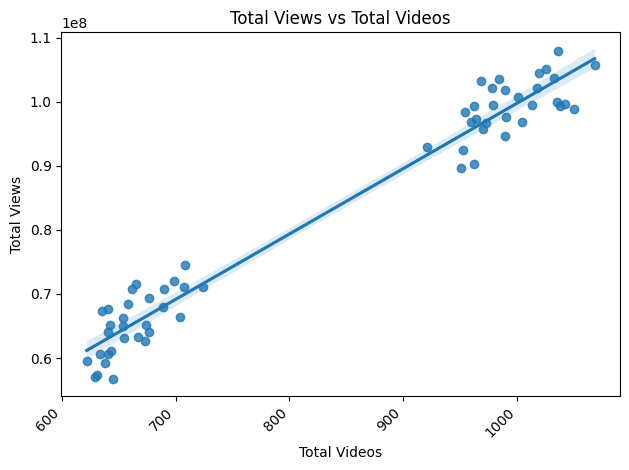

        total_views  total_videos
count  6.000000e+01     60.000000
mean   8.225318e+07    828.400000
std    1.770085e+07    170.134961
min    5.665754e+07    622.000000
25%    6.514869e+07    657.250000
50%    8.203921e+07    822.500000
75%    9.937930e+07    989.000000
max    1.078324e+08   1068.000000


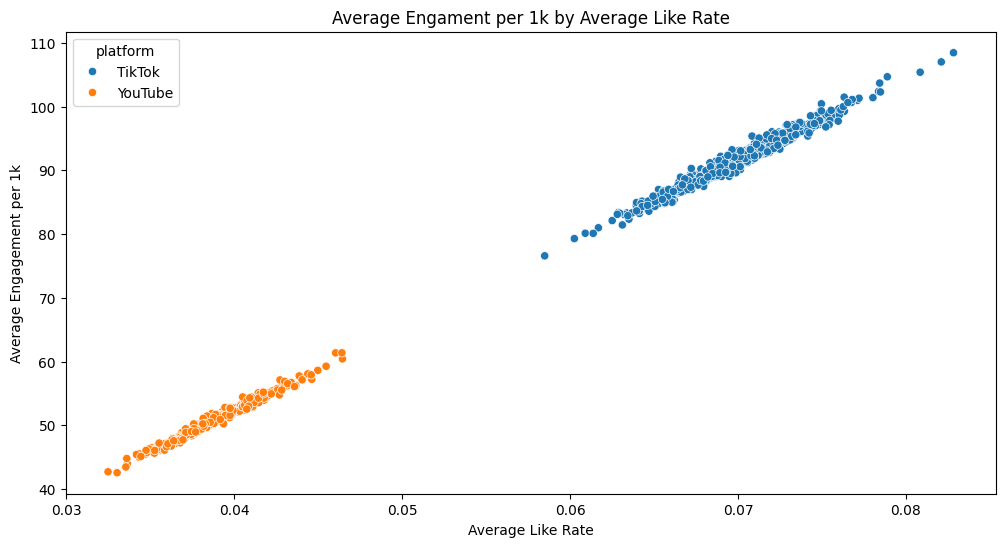

       avg_like_rate  avg_engagement_per_1k
count    1000.000000            1000.000000
mean        0.057960              75.878799
std         0.015464              20.263305
min         0.032481              42.553286
25%         0.039612              51.742040
50%         0.067228              88.186849
75%         0.070805              92.520398
max         0.082840             108.453476


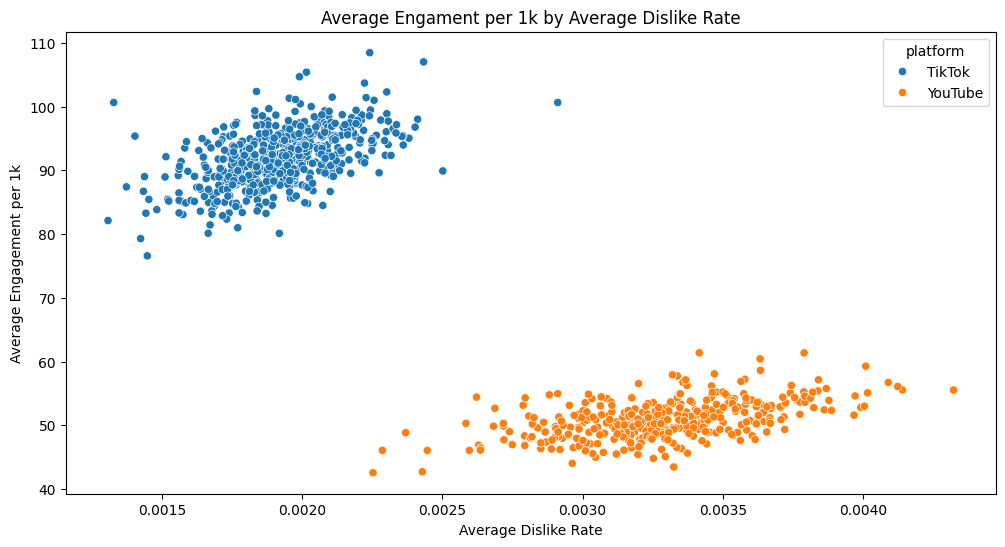

       avg_dislike_rate  avg_engagement_per_1k
count       1000.000000            1000.000000
mean           0.002449              75.878799
std            0.000713              20.263305
min            0.001307              42.553286
25%            0.001878              51.742040
50%            0.002075              88.186849
75%            0.003185              92.520398
max            0.004324             108.453476


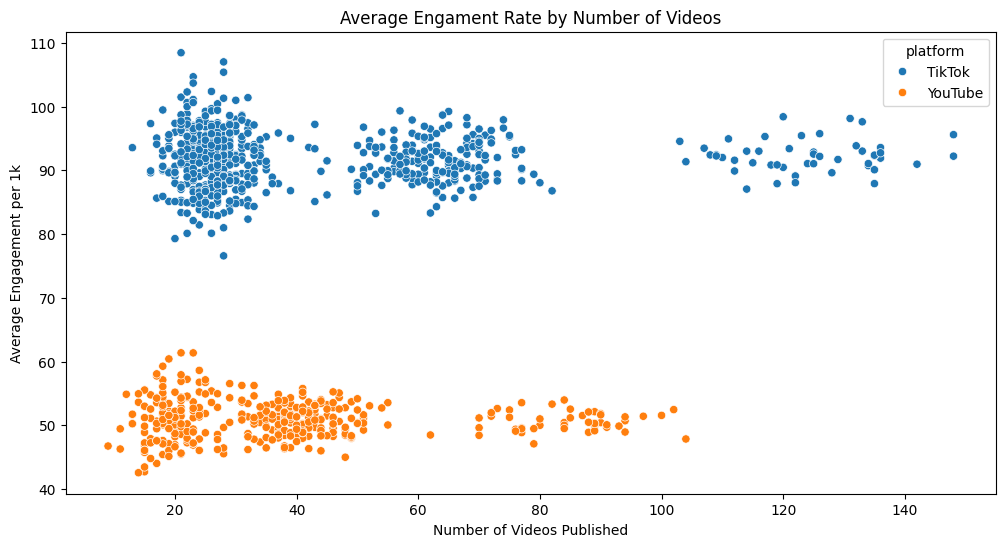

          n_videos  avg_engagement_per_1k
count  1000.000000            1000.000000
mean     42.465000              75.878799
std      26.342869              20.263305
min       9.000000              42.553286
25%      24.000000              51.742040
50%      32.000000              88.186849
75%      56.000000              92.520398
max     148.000000             108.453476


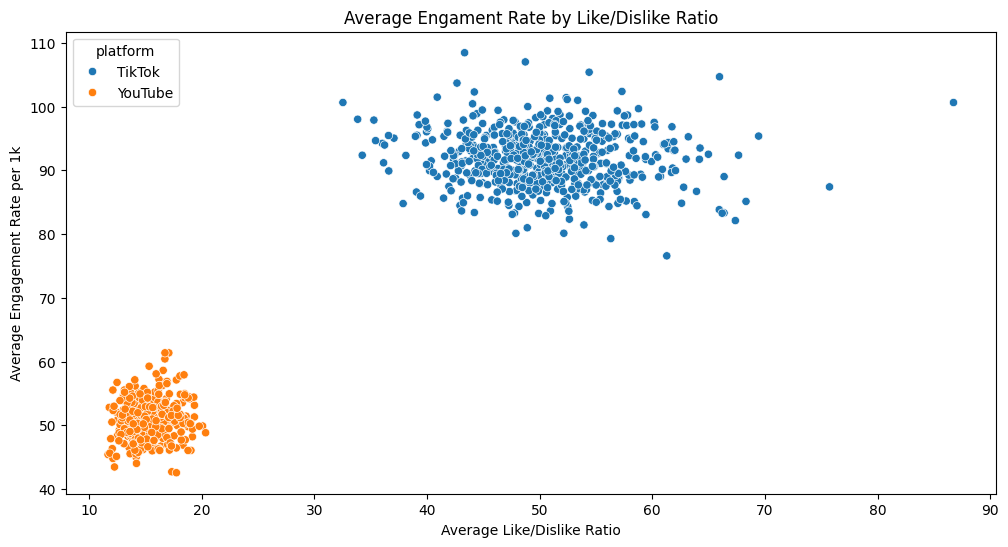

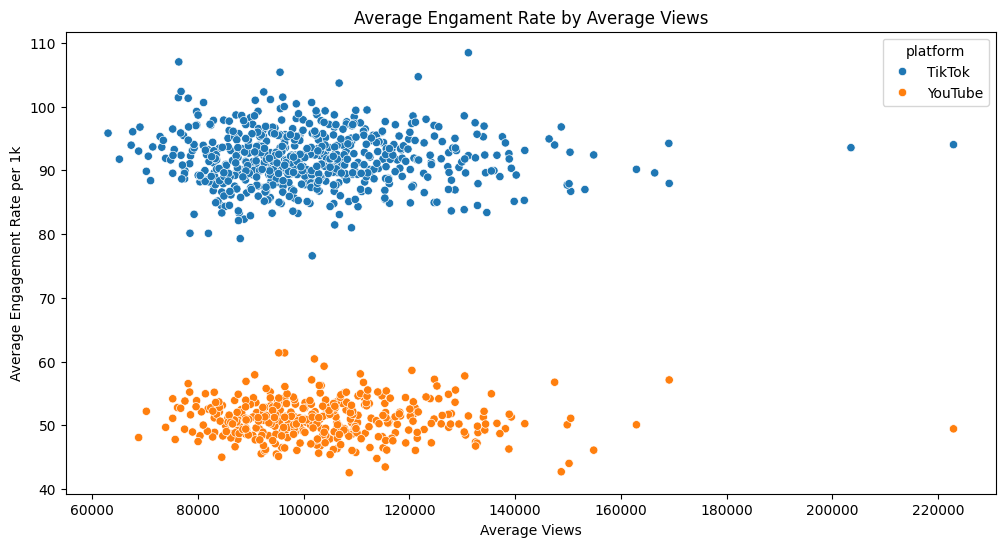

In [39]:
sns.regplot(data=cps_df, x="total_videos", y="total_views", scatter=True)
plt.title("Total Views vs Total Videos")
plt.xlabel("Total Videos")
plt.ylabel("Total Views")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
des_stats1 = cps_df[["total_views", "total_videos"]]
print(des_stats1.describe())
plt.figure(figsize=(12, 6))
sns.scatterplot(data=creators_df, x="avg_like_rate", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament per 1k by Average Like Rate")
plt.xlabel("Average Like Rate")
plt.ylabel("Average Engagement per 1k")
plt.show()
des_stats2 = creators_df[["avg_like_rate", "avg_engagement_per_1k"]]
print(des_stats2.describe())
plt.figure(figsize=(12, 6))
sns.scatterplot(data=creators_df, x="avg_dislike_rate", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament per 1k by Average Dislike Rate")
plt.xlabel("Average Dislike Rate")
plt.ylabel("Average Engagement per 1k")
plt.show()
des_stats3 = creators_df[["avg_dislike_rate", "avg_engagement_per_1k"]]
print(des_stats3.describe())
plt.figure(figsize=(12, 6))
sns.scatterplot(data=creators_df, x="n_videos", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament Rate by Number of Videos")
plt.xlabel("Number of Videos Published")
plt.ylabel("Average Engagement per 1k")
plt.show()
des_stats4 = creators_df[["n_videos", "avg_engagement_per_1k"]]
print(des_stats4.describe())
# keeping data visualization for creator_df in this section but just want to be clear 
# that below this was done later on
plt.figure(figsize=(12, 6))
sns.scatterplot(data=creators_df, x="avg_like_dislike_ratio", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament Rate by Like/Dislike Ratio")
plt.xlabel("Average Like/Dislike Ratio")
plt.ylabel("Average Engagement Rate per 1k")
plt.show()
plt.figure(figsize=(12, 6))
sns.scatterplot(data=creators_df, x="creator_avg_views", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament Rate by Average Views")
plt.xlabel("Average Views")
plt.ylabel("Average Engagement Rate per 1k")
plt.show()

So far we can see some candidates that can be good to analyze. Need to plot many more relationships to get a better picture. Lots of these pairs are intuitive to predict if there will be linear correlation or not, like channels with high video counts having high view counts. Want to explore more of the relationship between negative and positive feedback on a video with performance. Observing that TikTok seems to in general have higher engagement rates across the board compared to YouTube, would like to compare this to region and maybe upload time as well. 

One interesting thing to note is that videos with high dislike rates seem to earn more engagement on TikTok versus on YouTube. Another note: TikTok in general has lower dislike rates across the board than YouTube, but we can still see a clearer relationship in how those dislikes effect engagement.

Lets take a look at the hashtags dataset.

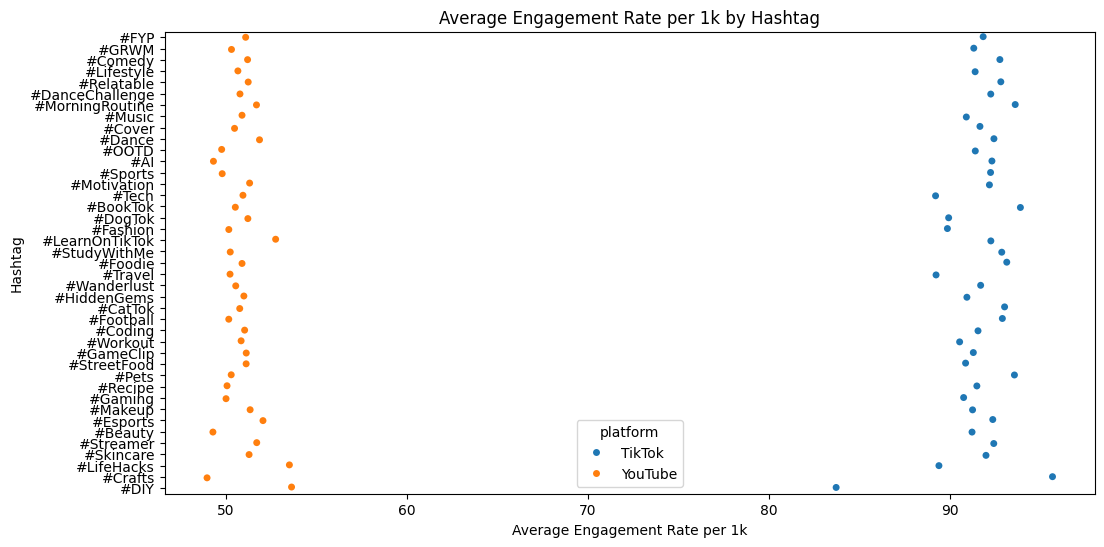

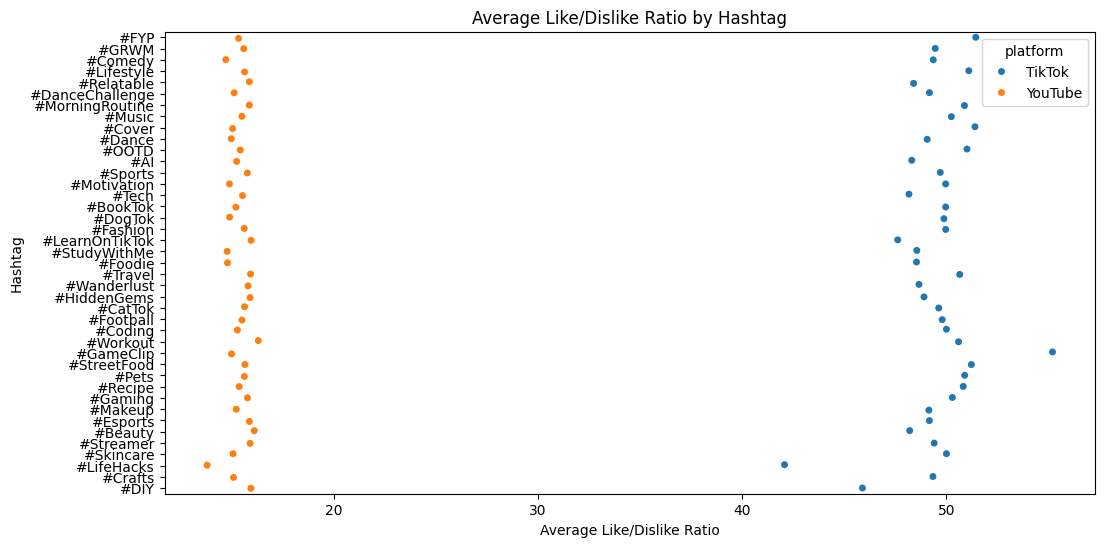

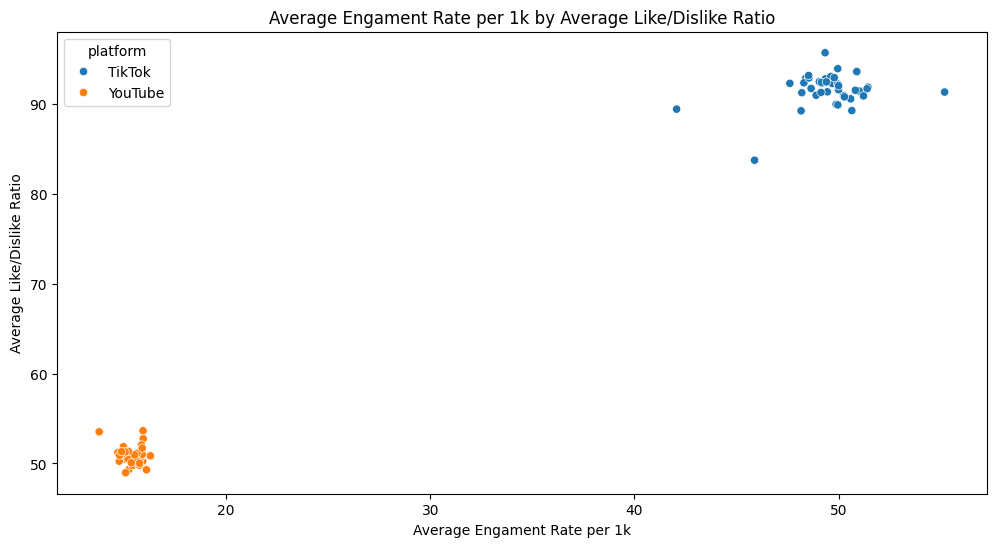

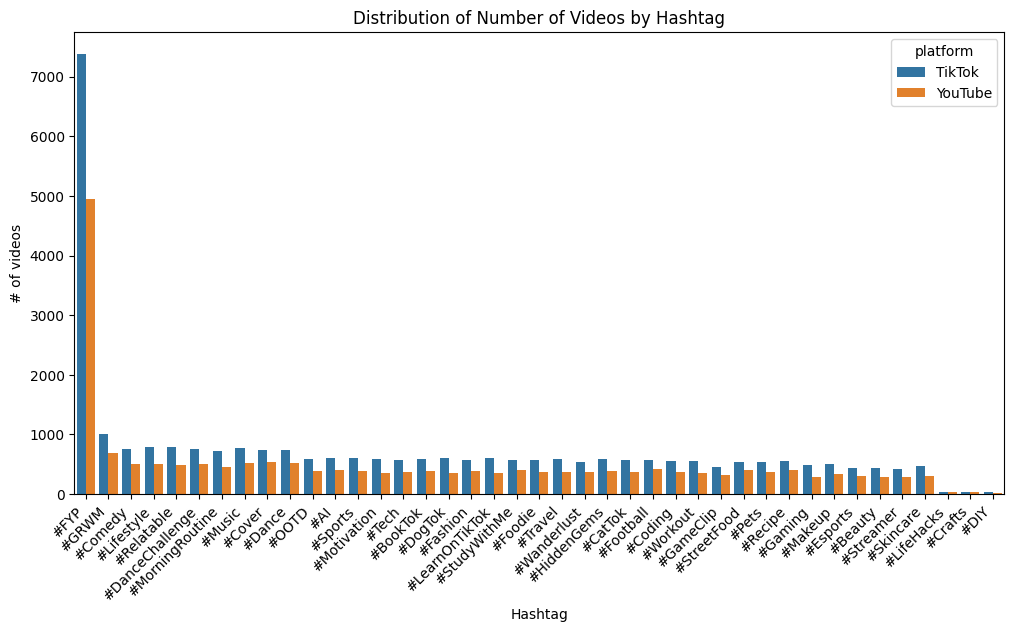

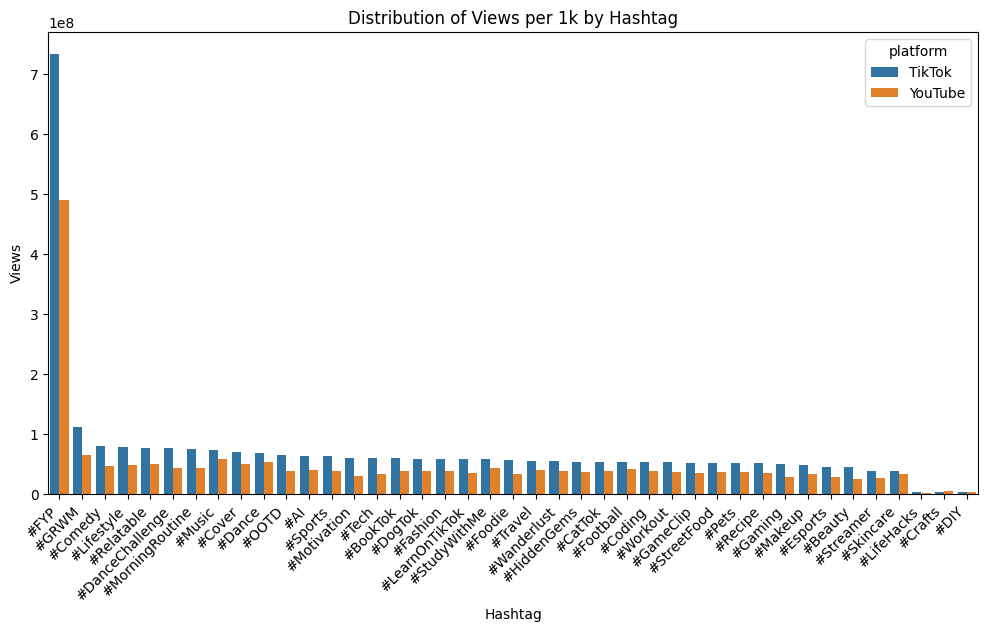

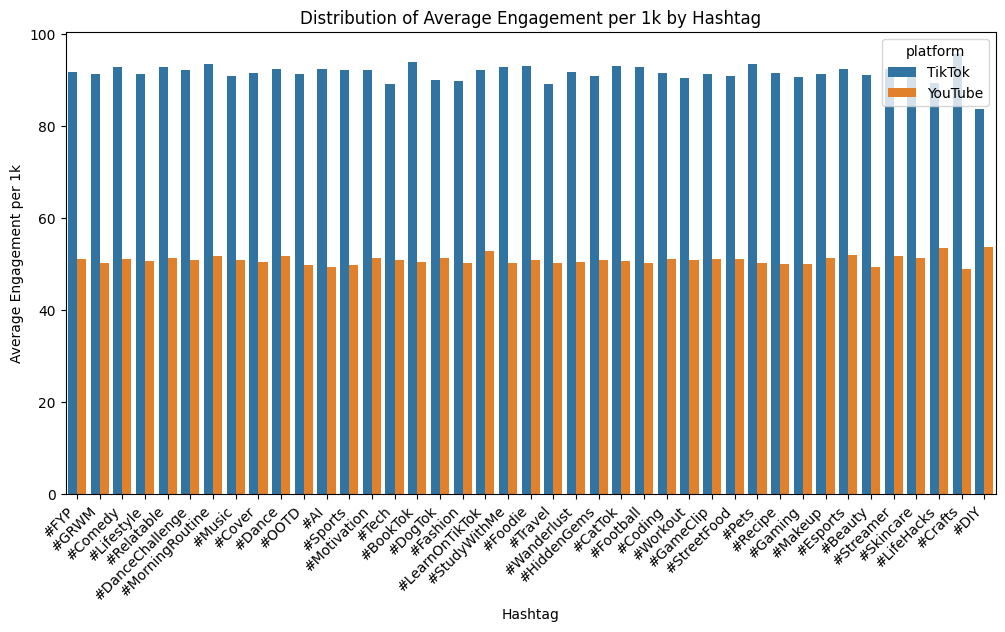

In [40]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=hashtags_df, x="avg_engagement_per_1k", y="hashtag", 
              hue ="platform")
plt.title("Average Engagement Rate per 1k by Hashtag")
plt.xlabel("Average Engagement Rate per 1k")
plt.ylabel("Hashtag")
plt.show()

plt.figure(figsize=(12, 6))
sns.stripplot(data=hashtags_df, x="avg_like_dislike_ratio", y="hashtag", 
              hue ="platform")
plt.title("Average Like/Dislike Ratio by Hashtag")
plt.xlabel("Average Like/Dislike Ratio")
plt.ylabel("Hashtag")
plt.show()

plt.figure(figsize=(12, 6))
sns.scatterplot(data=hashtags_df, x="avg_like_dislike_ratio", y="avg_engagement_per_1k", hue="platform")
plt.title("Average Engament Rate per 1k by Average Like/Dislike Ratio")
plt.xlabel("Average Engament Rate per 1k")
plt.ylabel("Average Like/Dislike Ratio")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=hashtags_df, x="hashtag", y="n_videos", hue="platform")
plt.title("Distribution of Number of Videos by Hashtag")
plt.xlabel("Hashtag")
plt.ylabel("# of videos")
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=hashtags_df, x="hashtag", y="views", hue="platform")
plt.title("Distribution of Views per 1k by Hashtag")
plt.xlabel("Hashtag")
plt.ylabel("Views")
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=hashtags_df, x="hashtag", y="avg_engagement_per_1k", hue="platform")
plt.title("Distribution of Average Engagement per 1k by Hashtag")
plt.xlabel("Hashtag")
plt.ylabel("Average Engagement per 1k")
plt.xticks(rotation=45, ha='right')
plt.show()


This is giving some useful info, here we can parse what hashtags are the most and least effective for engagement. So far I'm observing far more variance on TikTok data versus YouTube data, do creators have a better chance of going viral on TikTok because of the chance to be one of these outliers? Or is YouTube just more consistent in terms of expectations for engagement?
I'm also seeing that the same hashtags seem to perform similarly relative to each platform.

Lets explore some stuff from yt_tt_trends_ML_df, a data set that contains information on trends from Youtube and TikTok cleaned up with ML.

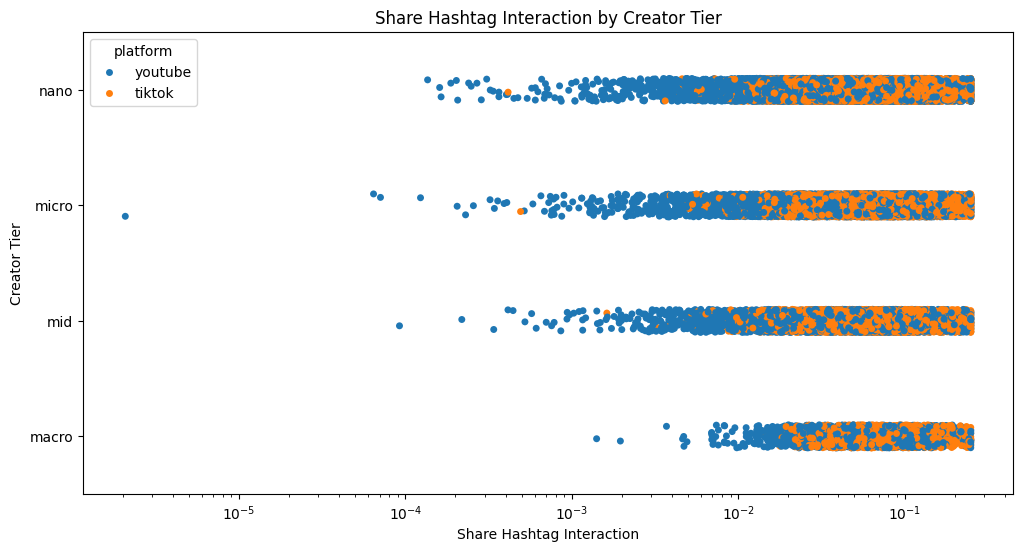

count    50000.000000
mean         0.066358
std          0.047522
min          0.000000
25%          0.031078
50%          0.054839
75%          0.090015
max          0.250000
Name: share_hashtag_interaction, dtype: float64


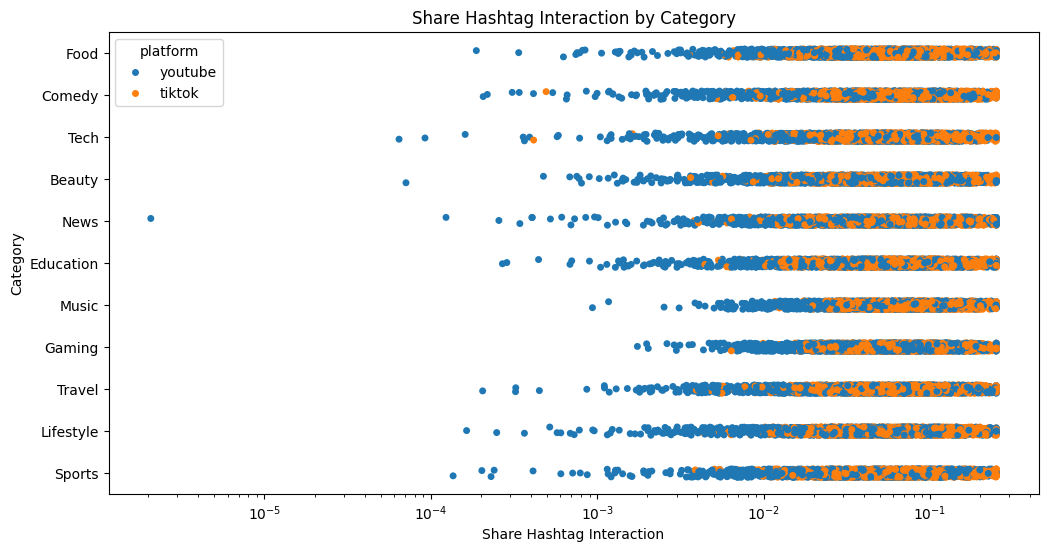

In [41]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=yt_tt_trends_ML_df, x="share_hashtag_interaction", y="creator_tier", 
              hue ="platform", log_scale=True)
plt.title("Share Hashtag Interaction by Creator Tier")
plt.xlabel("Share Hashtag Interaction")
plt.ylabel("Creator Tier")
plt.show()
des_stats5 = yt_tt_trends_ML_df["share_hashtag_interaction"]
print(des_stats5.describe())
plt.figure(figsize=(12, 6))
sns.stripplot(data=yt_tt_trends_ML_df, x="share_hashtag_interaction", y="category", 
              hue ="platform", log_scale=True)
plt.title("Share Hashtag Interaction by Category")
plt.xlabel("Share Hashtag Interaction")
plt.ylabel("Category")
plt.show()

Lets see if we can find a correlation between some of our different independent variables and virality. We will use point-biserial correlation, which can help identify correlation between a binary and continuous variable.

In [42]:
pb = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['engagement_per_1k'])
print(pb)
pb2 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['views'])
print(pb2)
pb3 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['duration_sec'])
print(pb3)
pb4 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['upload_hour'])
print(pb4)
pb5 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['likes'])
print(pb5)
pb6 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['comments'])
print(pb6)
pb7 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['shares'])
print(pb7)
pb8 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['saves'])
print(pb8)
pb9 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['engagement_velocity'])
print(pb9)
pb10 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['dislikes'])
print(pb10)
pb11 = pointbiserialr(yt_tt_trends_df['is_viral'], yt_tt_trends_df['like_dislike_ratio'])
print(pb11)

SignificanceResult(statistic=np.float64(0.4883902363955081), pvalue=np.float64(0.0))
SignificanceResult(statistic=np.float64(0.009014059486056752), pvalue=np.float64(0.04809877050824896))
SignificanceResult(statistic=np.float64(-0.05075348222805344), pvalue=np.float64(8.420962858227474e-29))
SignificanceResult(statistic=np.float64(0.006194596981091785), pvalue=np.float64(0.17438047034217705))
SignificanceResult(statistic=np.float64(0.1455661711282183), pvalue=np.float64(6.399544451427853e-226))
SignificanceResult(statistic=np.float64(0.13826787094065168), pvalue=np.float64(7.931323993458081e-204))
SignificanceResult(statistic=np.float64(0.14206626824284377), pvalue=np.float64(3.5340913978560775e-215))
SignificanceResult(statistic=np.float64(0.13138305840633108), pvalue=np.float64(4.5918040294044513e-184))
SignificanceResult(statistic=np.float64(0.0044178909386155575), pvalue=np.float64(0.332701314065859))
SignificanceResult(statistic=np.float64(0.047143670007373045), pvalue=np.float64(

Getting some interesting insights here. Most variables don't have a strong correlation to virality, save for engagement_rate_per_1k which has a very strong correlation value. Also of note is video duration leading to a negative correlation, implying that shorter videos may be better for going viral. Engagement rate is calculated by likes, shares, saves, and comments; yet neither of these variables stood out on their own, all falling around ~.14

Notes: Features set originally contained avg_engagement_per_1k but was causing data leakage due to being too closely correlated with virality already. Also was used to define virality metric so this makes sense.

PCA & Scree Plot

In [43]:
%%sql
DROP VIEW IF EXISTS viral_numeric_features;

CREATE VIEW viral_numeric_features AS
SELECT
    duration_sec,
    views,
    likes,
    comments,
    shares,
    saves,
    engagement_rate,
    upload_hour,
    trend_duration_days,
    engagement_velocity,
    dislikes,
    comment_ratio,
    share_rate,
    save_rate,
    like_dislike_ratio,
    creator_avg_views,
    title_length,
    has_emoji,
    avg_watch_time_sec,
    is_weekend,
    engagement_total,
    like_rate,
    dislike_rate,
    engagement_like_rate,
    engagement_comment_rate,
    engagement_share_rate
FROM yt_tt_trends_raw
WHERE duration_sec IS NOT NULL
  AND views IS NOT NULL
  AND likes IS NOT NULL;

DROP VIEW IF EXISTS viral_numeric_features_cleaned;

CREATE VIEW viral_numeric_features_cleaned AS
SELECT
    duration_sec,
    views,
    likes,
    comments,
    shares,
    saves,
    upload_hour,
    trend_duration_days,
    dislikes,
    comment_ratio,
    share_rate,
    save_rate,
    like_dislike_ratio,
    creator_avg_views,
    title_length,
    has_emoji,
    avg_watch_time_sec,
    is_weekend,
    like_rate,
    dislike_rate
FROM yt_tt_trends_raw
WHERE duration_sec IS NOT NULL
  AND views IS NOT NULL
  AND likes IS NOT NULL;

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

++
||
++
++

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

Running query in 'sqlite:////Users/alexvo/Desktop/Education/SDSU/CS-577 Prin & Tech of Data Science/Semester Project/data/virality_analysis.db'

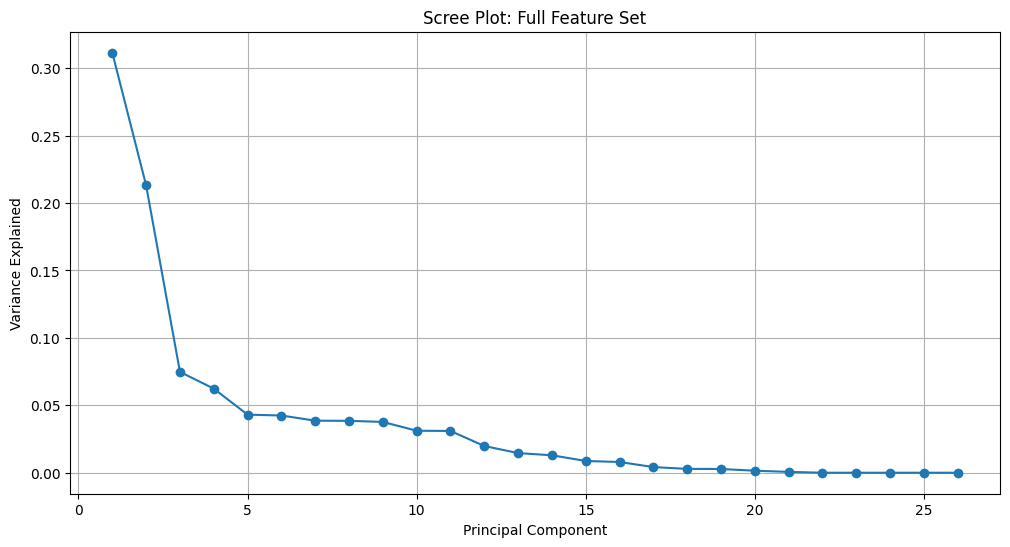

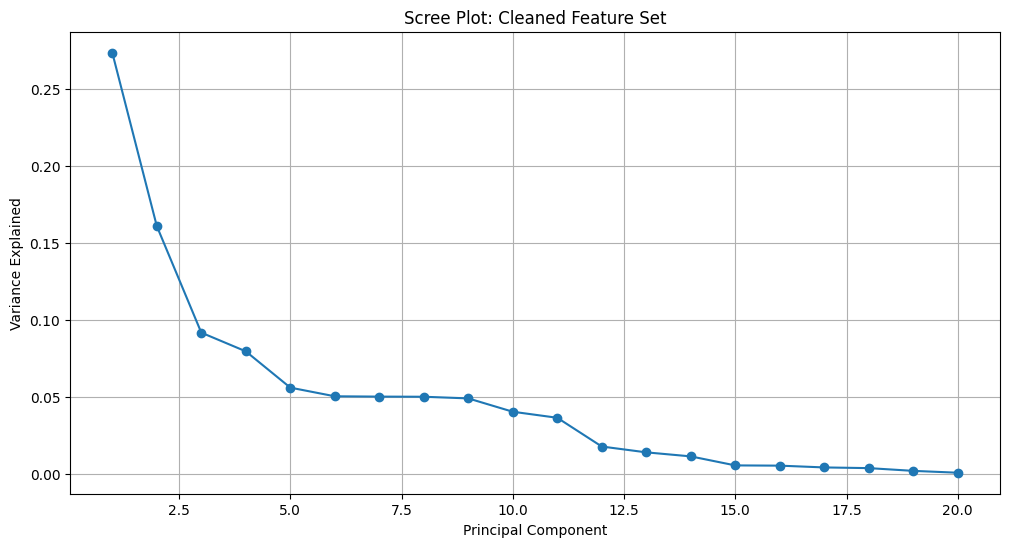

In [44]:
allFeatures_cleaned = %sql SELECT * FROM viral_numeric_features_cleaned;
allFeatures = %sql SELECT * FROM viral_numeric_features;

allFeatures = allFeatures.DataFrame()
allFeatures_cleaned = allFeatures_cleaned.DataFrame()

scaler_full = StandardScaler()
X_full_scaled = scaler_full.fit_transform(allFeatures)

pca_full = PCA()
pca_full.fit(X_full_scaled)

ev_full = pca_full.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(ev_full) + 1), ev_full, marker='o')
plt.title("Scree Plot: Full Feature Set")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

scaler_clean = StandardScaler()
X_clean_scaled = scaler_clean.fit_transform(allFeatures_cleaned)

pca_clean = PCA()
pca_clean.fit(X_clean_scaled)

ev_clean = pca_clean.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.arange(1, len(ev_clean) + 1), ev_clean, marker='o')
plt.title("Scree Plot: Cleaned Feature Set")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.grid(True)
plt.show()

In [45]:
important_features = pd.DataFrame(
    pca_full.components_.T,
    index=allFeatures.columns,
    columns=[f'PC{i+1}' for i in range(pca_full.n_components_)]
)

important_features.head()

pc1_importance = (
    important_features['PC1']
    .abs()
    .sort_values(ascending=False)
)
pc1_importance.head(10)

important_features_cleaned = pd.DataFrame(
    pca_clean.components_.T,
    index=allFeatures_cleaned.columns,
    columns=[f'PC{i+1}' for i in range(pca_clean.n_components_)]
)

important_features_cleaned.head()

pc1_importance_cleaned = (
    important_features_cleaned['PC1']
    .abs()
    .sort_values(ascending=False)
)
pc1_importance_cleaned.head(10)

likes            0.411212
shares           0.406623
comments         0.402671
saves            0.379798
views            0.364297
dislikes         0.311089
like_rate        0.188659
share_rate       0.178931
comment_ratio    0.171137
save_rate        0.140227
Name: PC1, dtype: float64

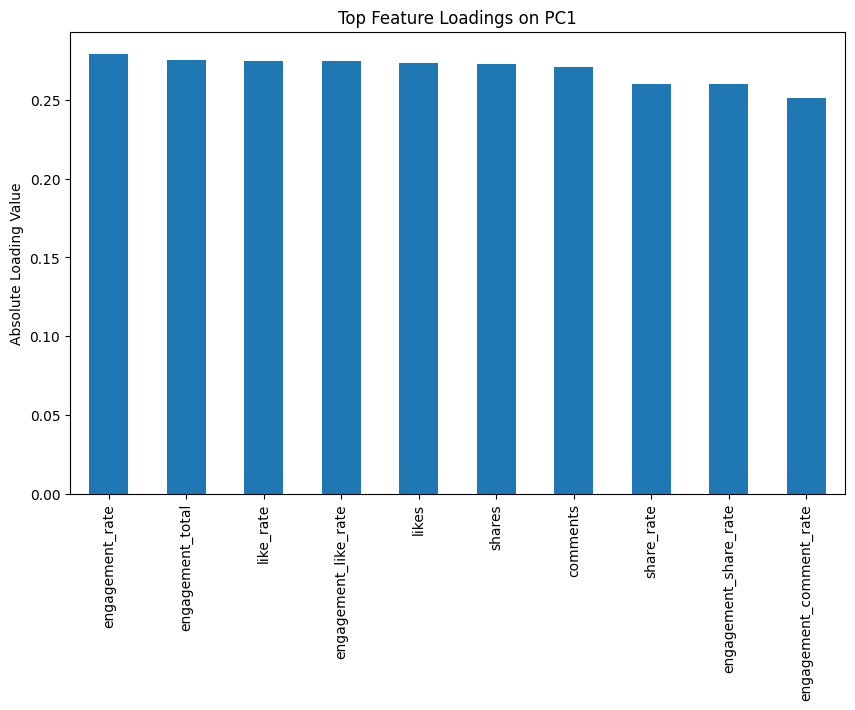

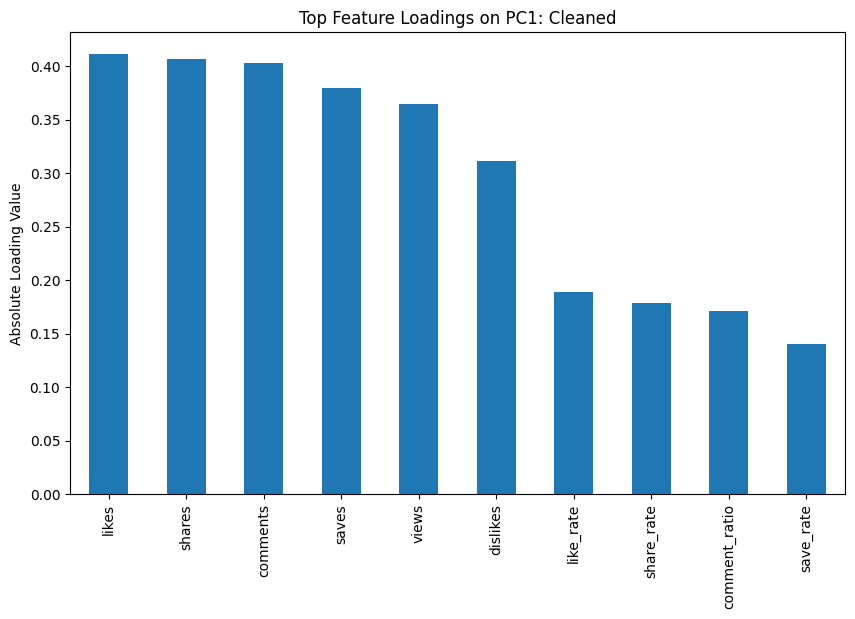

In [46]:
plt.figure(figsize=(10,6))
pc1_importance.head(10).plot(kind='bar')
plt.title("Top Feature Loadings on PC1")
plt.ylabel("Absolute Loading Value")
plt.show()

plt.figure(figsize=(10,6))
pc1_importance_cleaned.head(10).plot(kind='bar')
plt.title("Top Feature Loadings on PC1: Cleaned")
plt.ylabel("Absolute Loading Value")
plt.show()

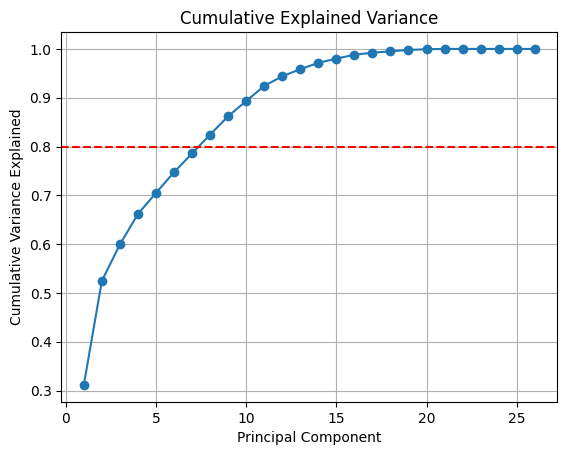

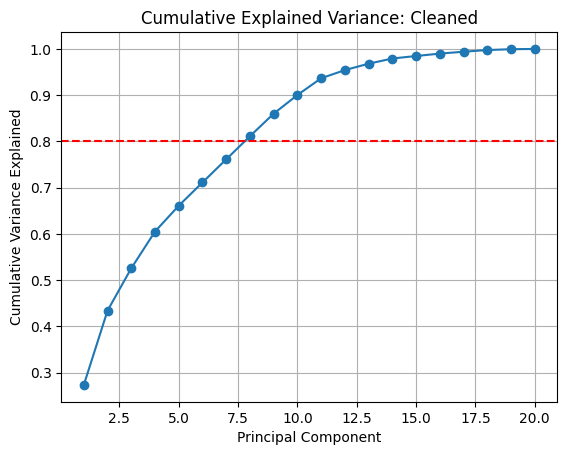

In [47]:
cum_var = np.cumsum(ev_full)
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Explained Variance")
plt.grid(True)
plt.show()

cum_var_clean = np.cumsum(ev_clean)
plt.plot(range(1, len(cum_var_clean)+1), cum_var_clean, marker='o')
plt.axhline(y=0.8, color='r', linestyle='--')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Explained Variance: Cleaned")
plt.grid(True)
plt.show()

In [48]:
final_features = pc1_importance.head(12).index.tolist()
print(final_features)

final_features_cleaned = pc1_importance_cleaned.head(12).index.tolist()
print(final_features_cleaned)

['engagement_rate', 'engagement_total', 'like_rate', 'engagement_like_rate', 'likes', 'shares', 'comments', 'share_rate', 'engagement_share_rate', 'engagement_comment_rate', 'comment_ratio', 'saves']
['likes', 'shares', 'comments', 'saves', 'views', 'dislikes', 'like_rate', 'share_rate', 'comment_ratio', 'save_rate', 'like_dislike_ratio', 'duration_sec']


Let's see if we can grab some more information using decision trees and random forests. Since virality is not linear we want to try and combine some of these features and make sense of them together rather than viewing individual relationships, or fitting a model. This could help us model interactions between features while also handling the imbalance of our is_viral target.

Finally, lets move on to modelling. Will start simple with linear regression

In [49]:
#im going to start with adding every feature that scored better than .05 on pbr
#features = ['duration_sec', 'upload_hour', 'shares', 'saves', 'like_dislike_ratio']
#leaving this commented out as we now have a feature set derived from PCA
features = final_features

#set X and Y for model
X = yt_tt_trends_df[features]
Y = yt_tt_trends_df['is_viral']

#split the data into training and testing sets (80/20 split)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=42, stratify=Y)

#set X and Y for model : Cleaned
X_cleaned = yt_tt_trends_df[features]
Y_Cleaned = yt_tt_trends_df['is_viral']

#split the data into training and testing sets (80/20 split) : Cleaned
X_train_c, X_test_c, Y_train_c, Y_test_c = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=42, stratify=Y)

#train the model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, Y_train)

#predictions
Y_pred = model.predict(X_test)
Y_prob = model.predict_proba(X_test)[:, 1]

#check scores
print("Accuracy:", accuracy_score(Y_test, Y_pred))
print("Precision:", precision_score(Y_test, Y_pred))
print("Recall:", recall_score(Y_test, Y_pred))
print("F1 Score:", f1_score(Y_test, Y_pred))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob))



Accuracy: 0.9514351081530782
Precision: 0.4262899262899263
Recall: 1.0
F1 Score: 0.5977605512489234
ROC-AUC: 0.9994471982621256


<Figure size 1200x600 with 0 Axes>

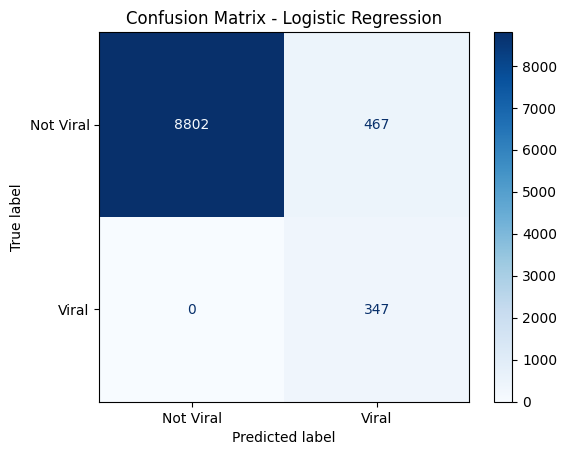

Logistic Regression CV F1 scores: [0.59265585 0.58913413 0.62353998 0.60364267 0.58863444]
Logistic Regression CV mean F1: 0.5995214129246584


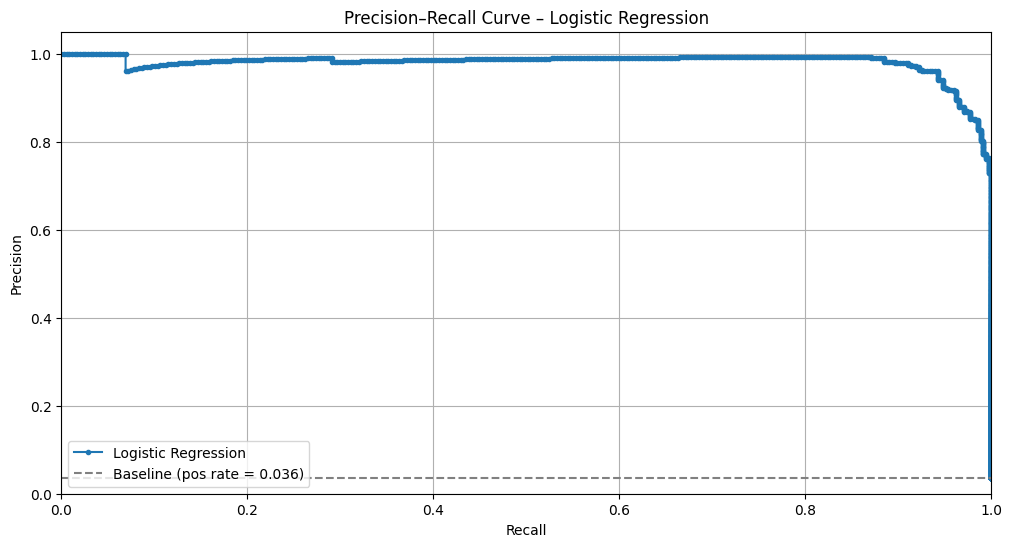

In [50]:
# Confusion Matrix - Logistic Regression
cm_lr = confusion_matrix(Y_test, Y_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr,
                                 display_labels=["Not Viral", "Viral"])

plt.figure(figsize=(12, 6))
disp_lr.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

# Cross-validation check (F1)
cv_scores_lr = cross_val_score(model, X, Y, cv=5, scoring='f1')
print("Logistic Regression CV F1 scores:", cv_scores_lr)
print("Logistic Regression CV mean F1:", cv_scores_lr.mean())

# Precision–Recall curve
precision_lr, recall_lr, thresh_lr = precision_recall_curve(Y_test, Y_prob)

plt.figure(figsize=(12, 6))
plt.plot(recall_lr, precision_lr, marker='.', label='Logistic Regression')

pos_rate = Y_test.mean()
plt.hlines(pos_rate, 0, 1, colors='gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – Logistic Regression')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend()
plt.show()

In [51]:
#using hyperparameter grid search to find the best features to use for the tree as we're having
#overfitting issues
param_grid = {
    'max_depth': [4, 6, 8, 10, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10, 20],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=5,
    scoring='f1'
)

grid_search.fit(X_train_c, Y_train_c)
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [52]:
dt_model = tree.DecisionTreeClassifier()

features1 = ['duration_sec', 'upload_hour', 'shares', 'saves', 'like_dislike_ratio']



X = yt_tt_trends_df[features]
Y = yt_tt_trends_df['is_viral']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=69, stratify=Y)

decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=20,
                                             min_samples_leaf=10, class_weight='balanced', random_state=42)
decision_tree_model = decision_tree_model.fit(X_train, Y_train)

Y_pred_dt = decision_tree_model.predict(X_test)
Y_prob_dt = decision_tree_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_dt))
print("Precision:", precision_score(Y_test, Y_pred_dt))
print("Recall:", recall_score(Y_test, Y_pred_dt))
print("F1 Score:", f1_score(Y_test, Y_pred_dt))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_dt))

print("Train Accuracy:", decision_tree_model.score(X_train, Y_train))
print("Test Accuracy:", decision_tree_model.score(X_test, Y_test))




Accuracy: 0.999896006655574
Precision: 1.0
Recall: 0.9971181556195965
F1 Score: 0.9985569985569985
ROC-AUC: 0.9985590778097982
Train Accuracy: 1.0
Test Accuracy: 0.999896006655574


Looks like most videos are not viral, wow who wouldve thought. Lets visualize this rough tree and see what we're working with before moving into generating a forest.

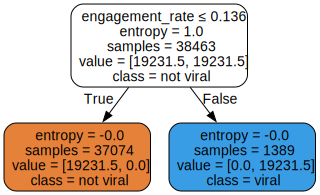

In [53]:
tree_data = tree.export_graphviz(decision_tree_model, out_file=None, feature_names=features, class_names=["not viral", "viral"], filled=True, rounded=True, special_characters=True, max_depth=3)

graph = graphviz.Source(tree_data)
graph

Nice so we can see even from just a partial view, our model is rarely returning viral, which is accurate with rare events but could be a little more balanced to try and catch most cases. Lets use this to generate a random forest to try and harness variance and prevent overfitting.

In [54]:
randomForest_model = RandomForestClassifier(n_estimators=300, random_state=69, n_jobs=-1, class_weight="balanced_subsample")

randomForest_model.fit(X_train, Y_train)

Y_pred_rt = randomForest_model.predict(X_test)
Y_prob_rt = randomForest_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_rt))
print("Precision:", precision_score(Y_test, Y_pred_rt))
print("Recall:", recall_score(Y_test, Y_pred_rt))
print("F1 Score:", f1_score(Y_test, Y_pred_rt))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_rt))

Accuracy: 0.999896006655574
Precision: 1.0
Recall: 0.9971181556195965
F1 Score: 0.9985569985569985
ROC-AUC: 0.9999996890878865


Looks like precision and recall have become meaningless since our events are so rare. Lets evaluate with a lower threshold.

In [55]:
randomForest_model = RandomForestClassifier(n_estimators=300, random_state=69, n_jobs=-1, class_weight="balanced_subsample")

randomForest_model.fit(X_train, Y_train)

Y_pred_rt = (Y_prob_rt >= 0.1).astype(int)
Y_prob_rt = randomForest_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_rt))
print("Precision:", precision_score(Y_test, Y_pred_rt))
print("Recall:", recall_score(Y_test, Y_pred_rt))
print("F1 Score:", f1_score(Y_test, Y_pred_rt))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_rt))

Accuracy: 0.9996880199667221
Precision: 0.9914285714285714
Recall: 1.0
F1 Score: 0.9956958393113343
ROC-AUC: 0.9999996890878865


Now we're seeing actual values for precision, recall, and F1, though accuracy has dropped which is expected with a lower threshold (and better since with rare events accuracy can be misleading). These values are still negligible so lets try and shift our model, removing constraints on depth to see if we can further define these smaller areas of our viral class. 

In [56]:
randomForest_model = RandomForestClassifier(n_estimators=300, random_state=69, n_jobs=-1, class_weight="balanced_subsample", max_depth=None, min_samples_leaf=1)

randomForest_model.fit(X_train, Y_train)

Y_pred_rt = (Y_prob_rt >= 0.1).astype(int)
Y_prob_rt = randomForest_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_rt))
print("Precision:", precision_score(Y_test, Y_pred_rt))
print("Recall:", recall_score(Y_test, Y_pred_rt))
print("F1 Score:", f1_score(Y_test, Y_pred_rt))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_rt))

Accuracy: 0.9996880199667221
Precision: 0.9914285714285714
Recall: 1.0
F1 Score: 0.9956958393113343
ROC-AUC: 0.9999996890878865


Negligible differences between the two seems like removing the constraints hasn't shifted our output and lowering our threshold proves more broad and clearer for pinning our rare viral event. Lets see if we can visualize this forest.

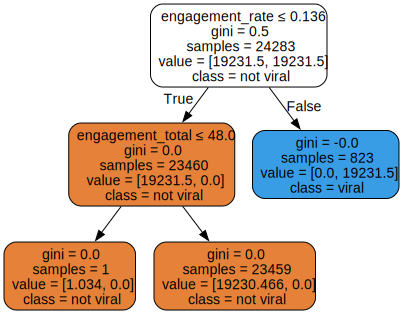

In [57]:
estimator = randomForest_model.estimators_[0]

forest_data = tree.export_graphviz(estimator, out_file=None, feature_names=features, class_names=["not viral", "viral"], filled=True, rounded=True, special_characters=True, max_depth=3)

graph = graphviz.Source(forest_data)
graph

Nice here we can see that while still rare this model catches rare, viral events from our data.

Ok so our decision tree and random forests models are a little too good, which could be explained by the models learning one feature that heavily determines virality, like engagement rate. 

<Figure size 1200x600 with 0 Axes>

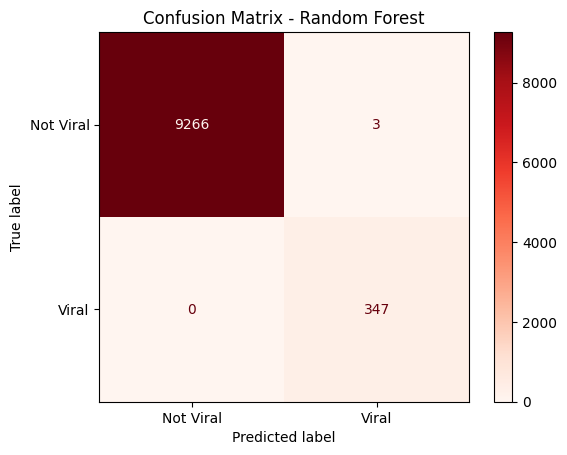

Random Forest CV F1 scores: [0.998557 1.       1.       1.       1.      ]
Random Forest CV mean F1: 0.9997113997113998


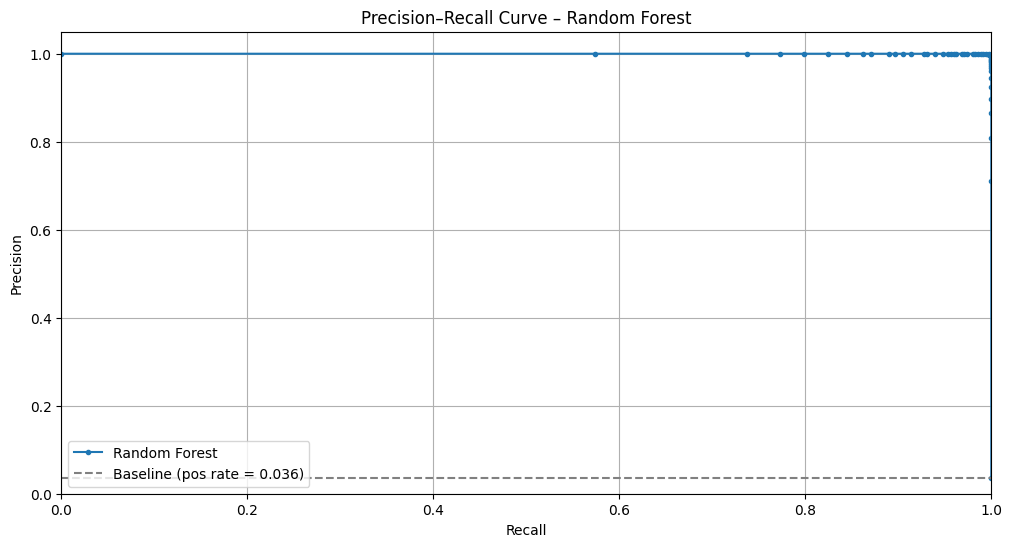

In [58]:
# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(Y_test, Y_pred_rt)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf,
                                 display_labels=["Not Viral", "Viral"])

plt.figure(figsize=(12, 6))
disp_rf.plot(cmap="Reds", values_format='d')
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Cross-validation check (F1)
cv_scores_rf = cross_val_score(randomForest_model, X, Y, cv=5, scoring='f1')
print("Random Forest CV F1 scores:", cv_scores_rf)
print("Random Forest CV mean F1:", cv_scores_rf.mean())

# Precision–Recall curve
precision_rf, recall_rf, thresh_rf = precision_recall_curve(Y_test, Y_prob_rt)

plt.figure(figsize=(12, 6))
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest')

pos_rate = Y_test.mean()
plt.hlines(pos_rate, 0, 1, colors='gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – Random Forest')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend()
plt.show()

False positives and negatives are near 0, so we're good here.
Cross validation scores are high, another good sign.

<Figure size 1200x600 with 0 Axes>

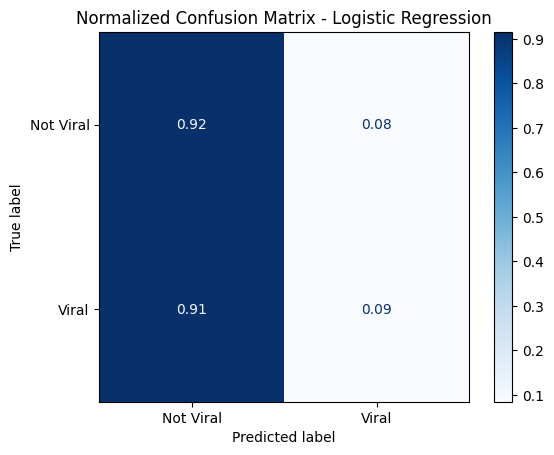

<Figure size 1200x600 with 0 Axes>

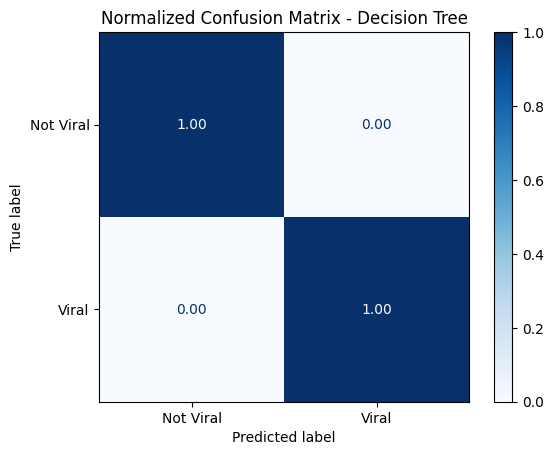

<Figure size 1200x600 with 0 Axes>

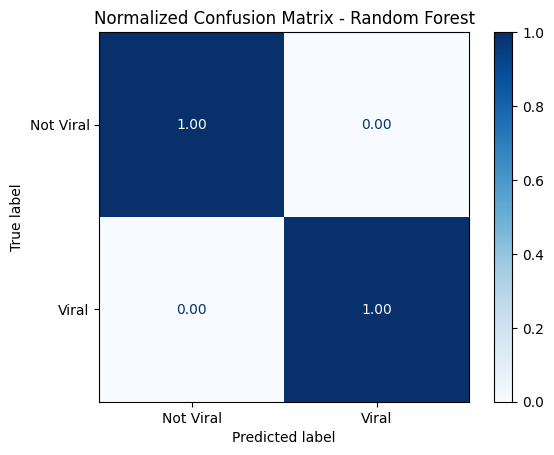

In [59]:
models = {
    "Logistic Regression": Y_pred,
    "Decision Tree": Y_pred_dt,
    "Random Forest": Y_pred_rt
}

for name, preds in models.items():
    cm = confusion_matrix(Y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels=["Not Viral", "Viral"])
    plt.figure(figsize=(12,6))
    disp.plot(cmap="Blues", values_format=".2f")
    plt.title(f"Normalized Confusion Matrix - {name}")
    plt.show()

Ok, at this point we can safely say that while the dt and random forest models are very accurate, they are also not too useful. Lets try other models: xgboost and svm.

In [60]:
#xgboost
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train, Y_train)

Y_pred_xgb = xgb_model.predict(X_test)
Y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_xgb))
print("Precision:", precision_score(Y_test, Y_pred_xgb))
print("Recall:", recall_score(Y_test, Y_pred_xgb))
print("F1 Score:", f1_score(Y_test, Y_pred_xgb))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_xgb))

Accuracy: 0.9987520798668885
Precision: 0.9970326409495549
Recall: 0.968299711815562
F1 Score: 0.9824561403508771
ROC-AUC: 0.9999524304466284


<Figure size 1200x600 with 0 Axes>

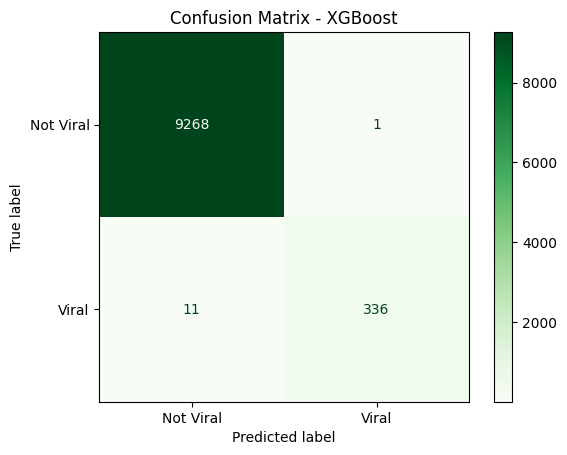

XGBoost CV F1 scores: [0.98850575 0.98398836 0.97226277 0.98129496 0.97971014]
XGBoost CV mean F1: 0.9811523969945546


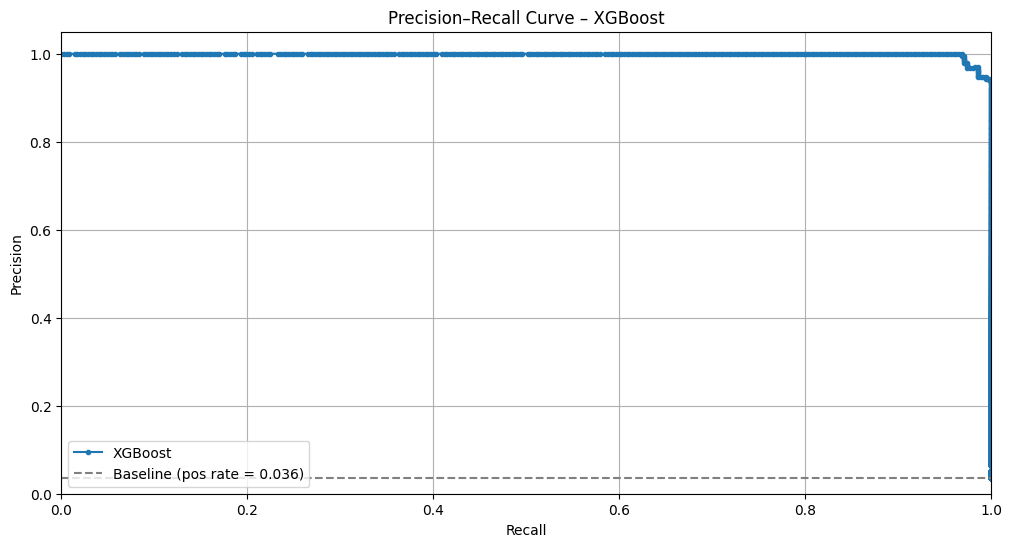

In [61]:
# Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(Y_test, Y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb,
                                  display_labels=["Not Viral", "Viral"])

plt.figure(figsize=(12, 6))
disp_xgb.plot(cmap="Greens", values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Cross-validation check (F1)
cv_scores_xgb = cross_val_score(xgb_model, X, Y, cv=5, scoring='f1')
print("XGBoost CV F1 scores:", cv_scores_xgb)
print("XGBoost CV mean F1:", cv_scores_xgb.mean())

# Precision–Recall curve
precision_xgb, recall_xgb, thresh_xgb = precision_recall_curve(Y_test, Y_prob_xgb)

plt.figure(figsize=(12, 6))
plt.plot(recall_xgb, precision_xgb, marker='.', label='XGBoost')

pos_rate = Y_test.mean()
plt.hlines(pos_rate, 0, 1, colors='gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – XGBoost')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend()
plt.show()


In [62]:
#svm
svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)
svm_model.fit(X_train, Y_train)

Y_pred_svm = svm_model.predict(X_test)
Y_prob_svm = svm_model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(Y_test, Y_pred_svm))
print("Precision:", precision_score(Y_test, Y_pred_svm))
print("Recall:", recall_score(Y_test, Y_pred_svm))
print("F1 Score:", f1_score(Y_test, Y_pred_svm))
print("ROC-AUC:", roc_auc_score(Y_test, Y_prob_svm))

Accuracy: 0.6600457570715474
Precision: 0.06517857142857143
Recall: 0.6311239193083573
F1 Score: 0.1181548421904505
ROC-AUC: 0.6931511968717267


<Figure size 1200x600 with 0 Axes>

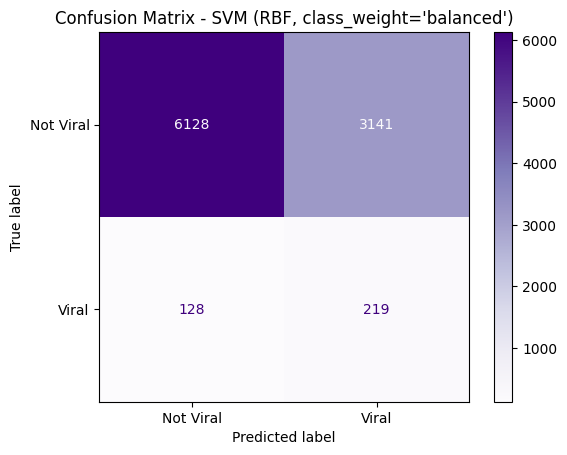

SVM CV F1 scores: [0.12084433 0.11481769 0.11952602 0.12005533 0.1133799 ]
SVM CV mean F1: 0.11772465222724889


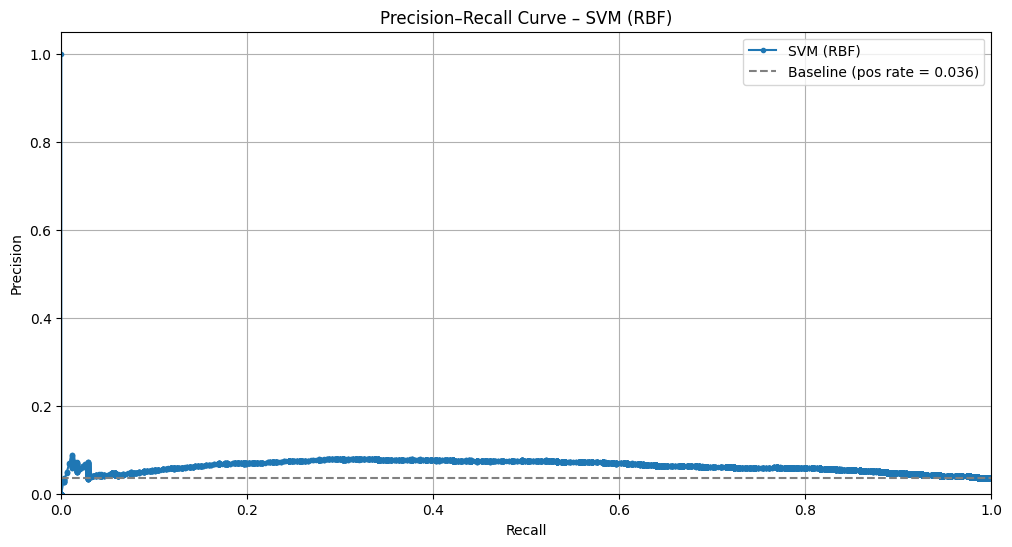

In [64]:
# Confusion Matrix - SVM
cm_svm = confusion_matrix(Y_test, Y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm,
                                  display_labels=["Not Viral", "Viral"])

plt.figure(figsize=(12, 6))
disp_svm.plot(cmap="Purples", values_format='d')
plt.title("Confusion Matrix - SVM (RBF, class_weight='balanced')")
plt.show()

# Cross-validation check (F1)
cv_scores_svm = cross_val_score(svm_model, X, Y, cv=5, scoring='f1')
print("SVM CV F1 scores:", cv_scores_svm)
print("SVM CV mean F1:", cv_scores_svm.mean())

# Precision–Recall curve
precision_svm, recall_svm, thresh_svm = precision_recall_curve(Y_test, Y_prob_svm)

plt.figure(figsize=(12, 6))
plt.plot(recall_svm, precision_svm, marker='.', label='SVM (RBF)')

pos_rate = Y_test.mean()
plt.hlines(pos_rate, 0, 1, colors='gray', linestyles='--',
           label=f'Baseline (pos rate = {pos_rate:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve – SVM (RBF)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.legend()
plt.show()

Lets visualize the performance of all our models used.

<Figure size 1200x600 with 0 Axes>

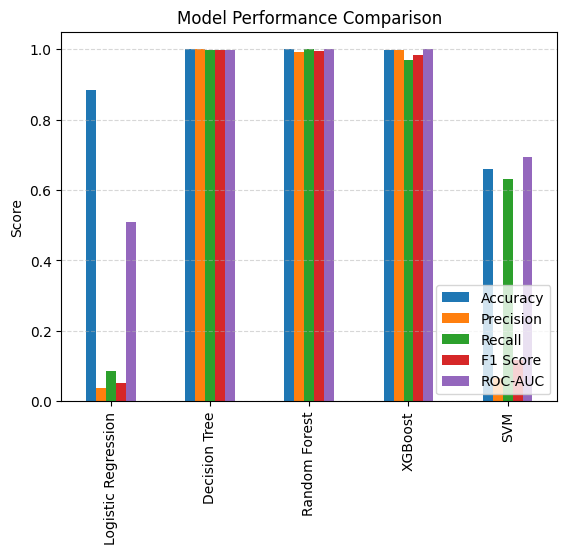

<Figure size 1200x600 with 0 Axes>

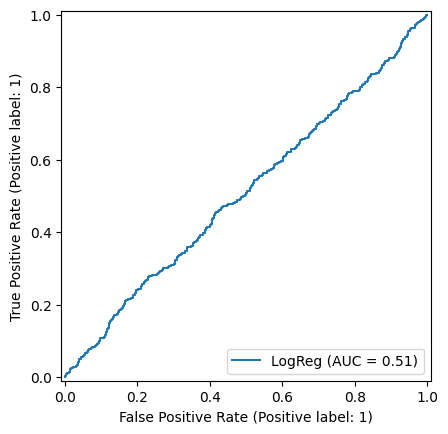

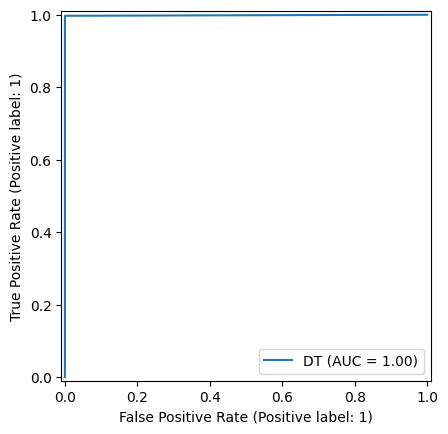

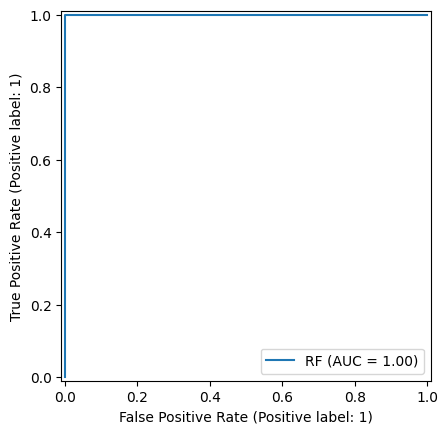

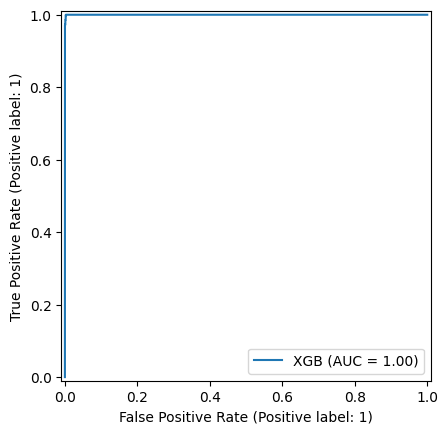

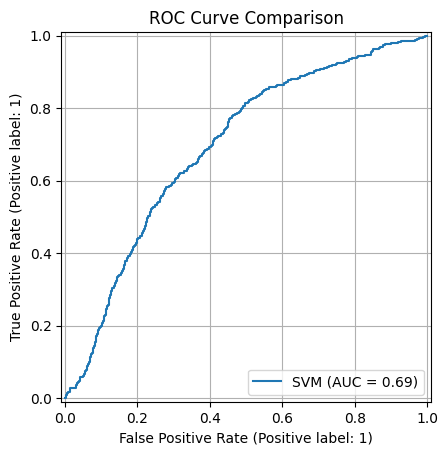

In [63]:
model_scores = {
    "Logistic Regression": [
        accuracy_score(Y_test, Y_pred),
        precision_score(Y_test, Y_pred),
        recall_score(Y_test, Y_pred),
        f1_score(Y_test, Y_pred),
        roc_auc_score(Y_test, Y_prob)
    ],
    "Decision Tree": [
        accuracy_score(Y_test, Y_pred_dt),
        precision_score(Y_test, Y_pred_dt),
        recall_score(Y_test, Y_pred_dt),
        f1_score(Y_test, Y_pred_dt),
        roc_auc_score(Y_test, Y_prob_dt)
    ],
    "Random Forest": [
        accuracy_score(Y_test, Y_pred_rt),
        precision_score(Y_test, Y_pred_rt),
        recall_score(Y_test, Y_pred_rt),
        f1_score(Y_test, Y_pred_rt),
        roc_auc_score(Y_test, Y_prob_rt)
    ],
    "XGBoost": [
        accuracy_score(Y_test, Y_pred_xgb),
        precision_score(Y_test, Y_pred_xgb),
        recall_score(Y_test, Y_pred_xgb),
        f1_score(Y_test, Y_pred_xgb),
        roc_auc_score(Y_test, Y_prob_xgb)
    ],
    "SVM": [
        accuracy_score(Y_test, Y_pred_svm),
        precision_score(Y_test, Y_pred_svm),
        recall_score(Y_test, Y_pred_svm),
        f1_score(Y_test, Y_pred_svm),
        roc_auc_score(Y_test, Y_prob_svm)
    ]
}

score_df = pd.DataFrame(model_scores, 
                        index=["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC"]).round(4)
score_df

plt.figure(figsize=(12,6))
score_df.T.plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(12,6))
for name, prob in {
    "LogReg": Y_prob,
    "DT": Y_prob_dt,
    "RF": Y_prob_rt,
    "XGB": Y_prob_xgb,
    "SVM": Y_prob_svm
}.items():
    RocCurveDisplay.from_predictions(Y_test, prob, name=name)

plt.title("ROC Curve Comparison")
plt.grid(True)
plt.show()